In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.regressor import PredictionError

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, max_error
from yellowbrick.regressor import PredictionError
import os
import pandas as pd
import matplotlib.pyplot as plt


class DistrictAnalysis:
    def __init__(self, csv_file,year):
        self.df_main = pd.read_csv(csv_file)
        self.year = year
        self.plot_folder = "/home/ravi/myfolder/project/artpark/dengue data/plots"
        os.makedirs(self.plot_folder, exist_ok=True)

    def pop_mean(self):
        self.df_main = self.df_main[self.df_main['Year'].isin([2017,2018,2019,2022])]
        #self.df_main['Case_Count'] = self.df_main['Case_Count'] / (self.df_main['Population'] / 1000000)
        return self.df_main

    def process_district_data(self, district_name):
        df_c = self.df_main.loc[self.df_main['District'] == district_name]
        df_c = df_c.dropna().reset_index(drop=True)
        return df_c

    def split_train_test(self, df):
        train_data = df[~(df['Year'].isin([self.year]))]
        

        test_data = df[df['Year'] == self.year]
        

        # Extracting features (X) and target variable (Y) for train and test sets
        x_train = train_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_train = train_data["Case_Count"]

        x_test = test_data[["2m_Temperature", "2m_Dewpoint_Temperature", "Total_Precipitation"]]
        y_test = test_data["Case_Count"]

        # Standardize features
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train)
        x_test_scaled = scaler.transform(x_test)
        
        return x_train_scaled, x_test_scaled, y_train, y_test

    def lasso_regression(self, x_train, x_test, y_train, y_test):
        lasso_regressor = Lasso(random_state=42)
        param_grid = {
            'alpha': [0.0001, 0.001, 0.01,0.1,0.2,0.5,1,2,5,10]  
        }
        grid_search = GridSearchCV(estimator=lasso_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(x_train, y_train)
        best_lasso_regressor = grid_search.best_estimator_
        y_pred = best_lasso_regressor.predict(x_test)
        mse = mean_squared_error(y_test, y_pred)
        rmse = mse**0.5
        return y_pred,rmse
    
    
    def calculate_error_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        explained_variance = explained_variance_score(y_test, y_pred)
        median_ae = median_absolute_error(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        error_metrics = pd.DataFrame({
            'Error Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)',
                             'R-squared (R2)', 'Explained Variance Score',
                             'Median Absolute Error', 'Maximum Error'],
            'Value': [mse, mae, r2, explained_variance, median_ae, max_err]
        })
        return error_metrics
    
    def plot_prediction(self, district_name,rmse, y_pred, y_test):
        mse = mean_squared_error(y_test, y_pred)

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(y_test)), y_test, color='blue', label='Actual')
        plt.plot(range(len(y_pred)), y_pred, color='red', marker='o', linestyle='-',
                 linewidth=2, markersize=6, label='Predicted')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.title(f'Actual vs Predicted Values for {district_name}')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.text(0.02, 0.88, f'RMSE: {rmse:.2f}', transform=plt.gca().transAxes, color='red',
                 weight='bold', verticalalignment='top', fontsize=12)

        # Save the plot
        district_plot_folder = os.path.join(self.plot_folder, district_name, 'Lasso')
        os.makedirs(district_plot_folder, exist_ok=True)  # Create the folder if it doesn't exist
        plt.savefig(os.path.join(district_plot_folder, f'{self.year}prediction_plot.png'))

        plt.show()

    def plot_yellowbrick_prediction_error(self, district_name, x_train, y_train, x_test, y_test):
        visualizer = PredictionError(Lasso(random_state=42))
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        
        plt.title(f'Prediction Error for {district_name}')
        visualizer.poof()
        
    def plot_yellowbrick_residuals(self, district_name, x_train, y_train, x_test, y_test):
        rf_regressor = RandomForestRegressor(random_state=42)
        rf_regressor.fit(x_train, y_train)
        y_pred = rf_regressor.predict(x_test)

        visualizer = ResidualsPlot(rf_regressor)
        visualizer.score(x_test, y_test)

        plt.title(f'Residuals Plot for {district_name}')
        visualizer.show()
        


    def analyze_districts(self):
        unique_districts = self.df_main['District'].unique()
        all_district_data = []
        for district_name in unique_districts:
            print(f"Analyzing District: {district_name}")
            district_data = self.process_district_data(district_name)
            x_train, x_test, y_train, y_test = self.split_train_test(district_data)
            #self.plot_yellowbrick_prediction_error(district_name, x_train, y_train, x_test, y_test)
            y_pred_svr, rmse_svr = self.lasso_regression(x_train, x_test, y_train, y_test)
            performance = "Good" if rmse_svr < 2 else "Bad"
    
            # Create a dictionary for each district's data
            district_data = {
                "district": district_name,
                f"{self.year}_rmse": rmse_svr,
                f"{self.year}_performance": performance
            }
    
            all_district_data.append(district_data)
            final_df = pd.DataFrame(all_district_data)
            self.plot_prediction(district_name,rmse_svr, y_pred_svr, y_test)
            print("=" * 100)
        return final_df

    





Analyzing District: BAGALKOTE


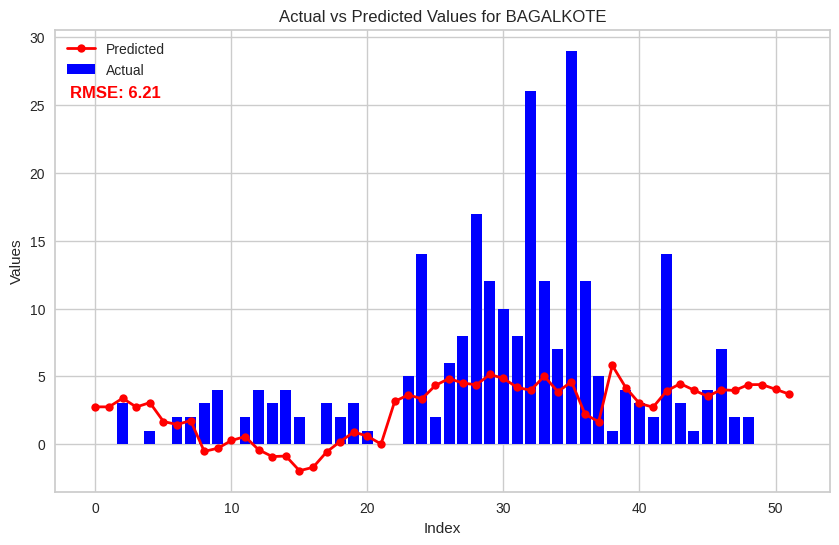

Analyzing District: BALLARI


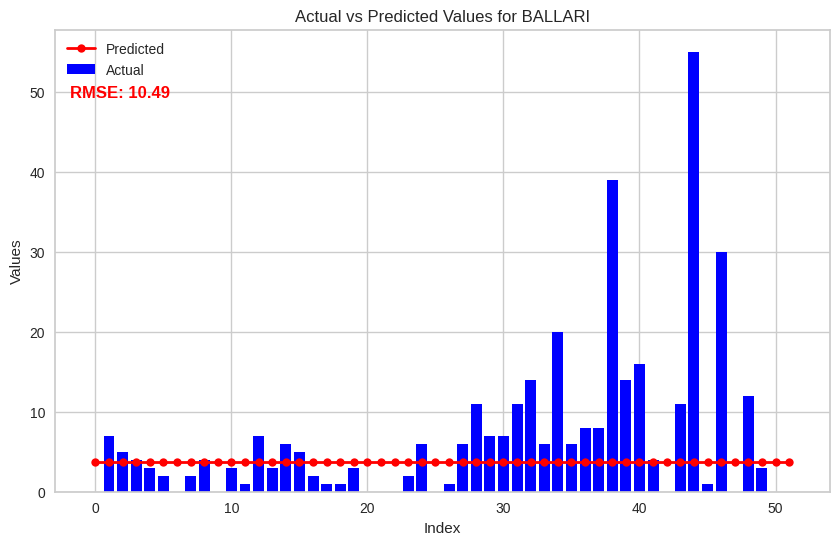

Analyzing District: BELAGAVI


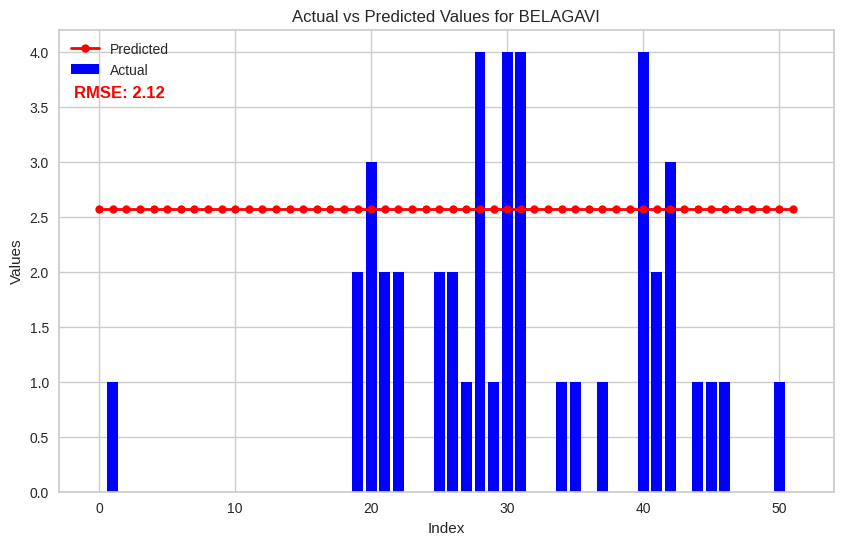

Analyzing District: BENGALURU RURAL


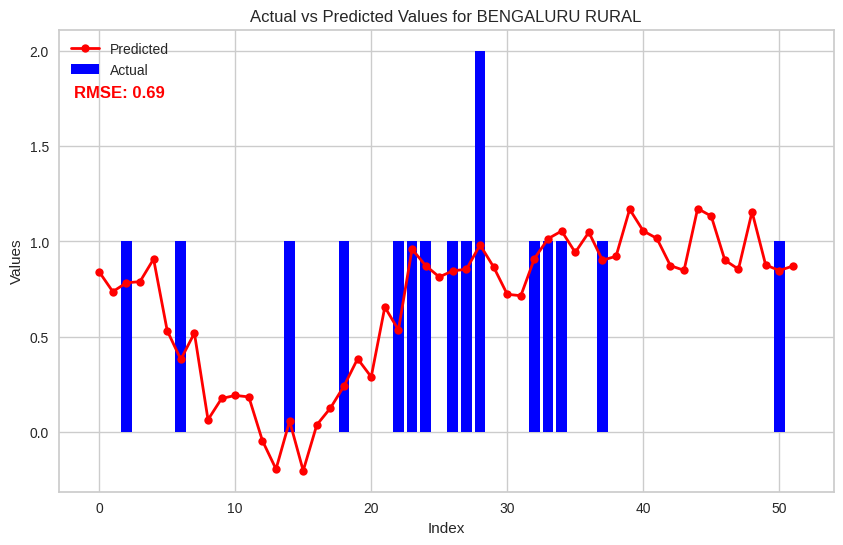

Analyzing District: BENGALURU URBAN


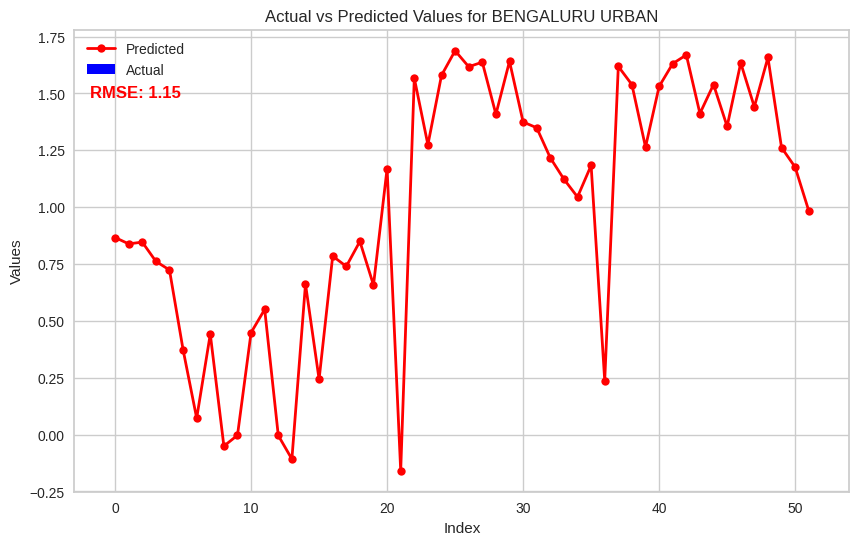

Analyzing District: BIDAR


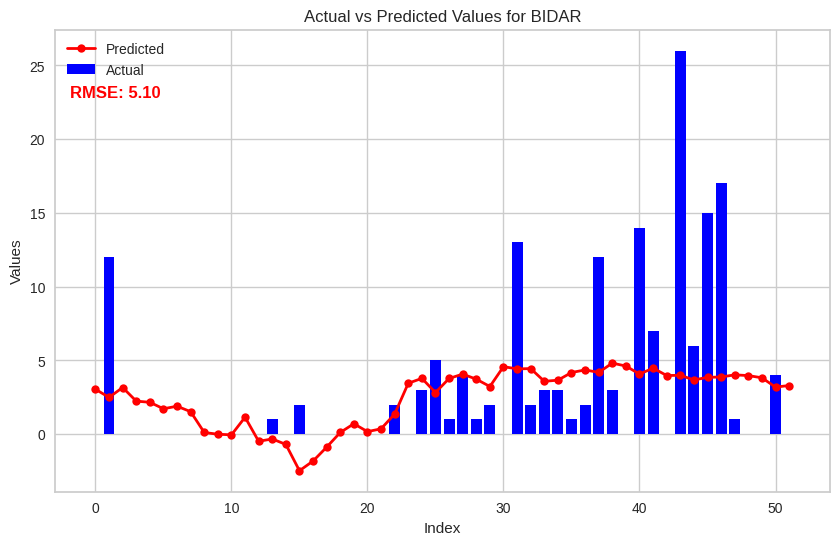

Analyzing District: CHAMARAJANAGARA


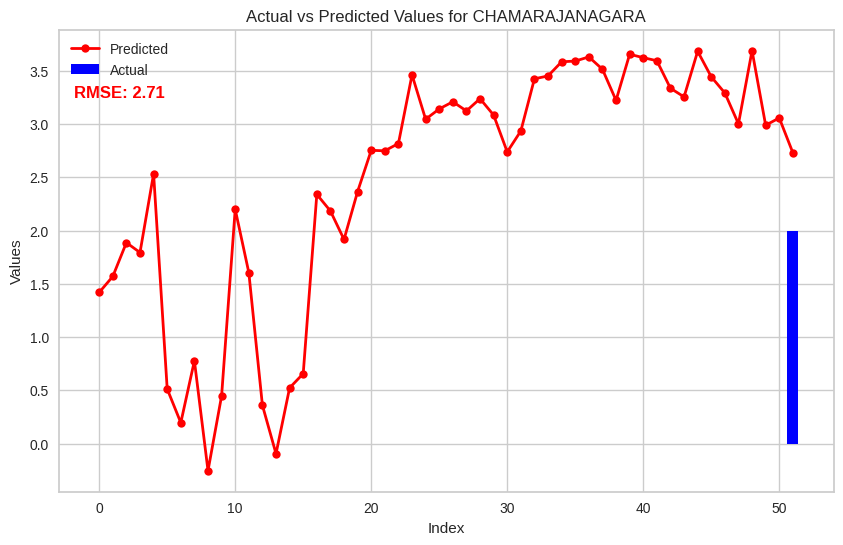

Analyzing District: CHIKKABALLAPURA


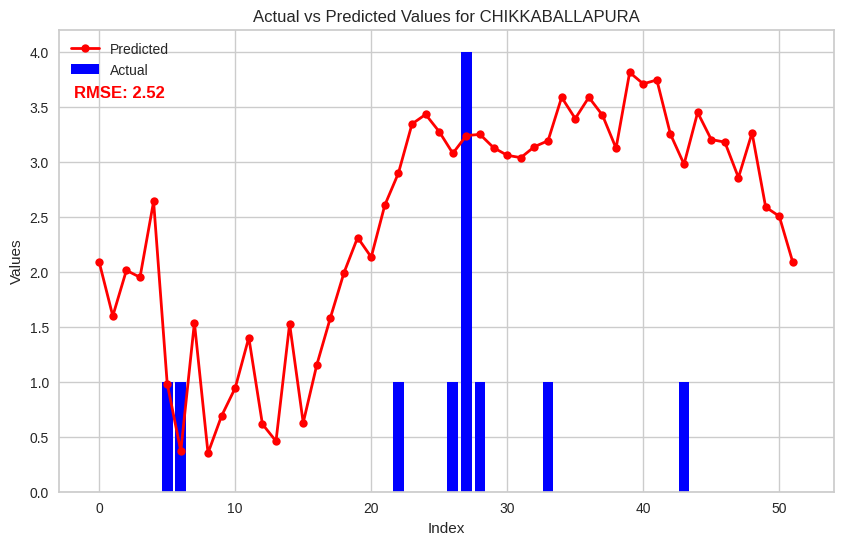

Analyzing District: CHIKKAMAGALURU


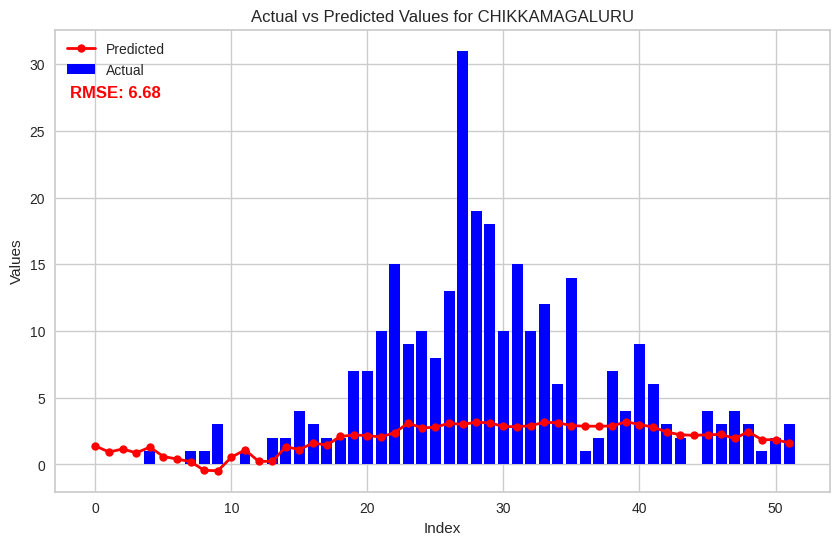

Analyzing District: CHITRADURGA


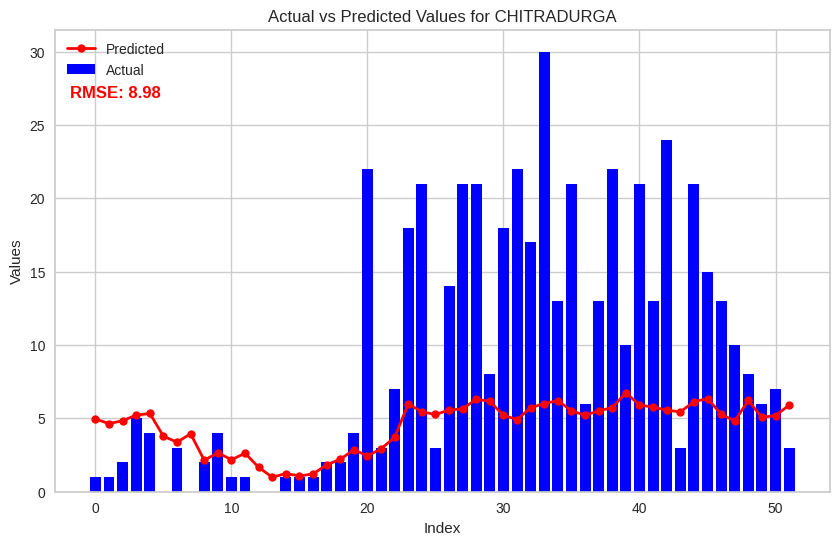

Analyzing District: DAKSHINA KANNADA


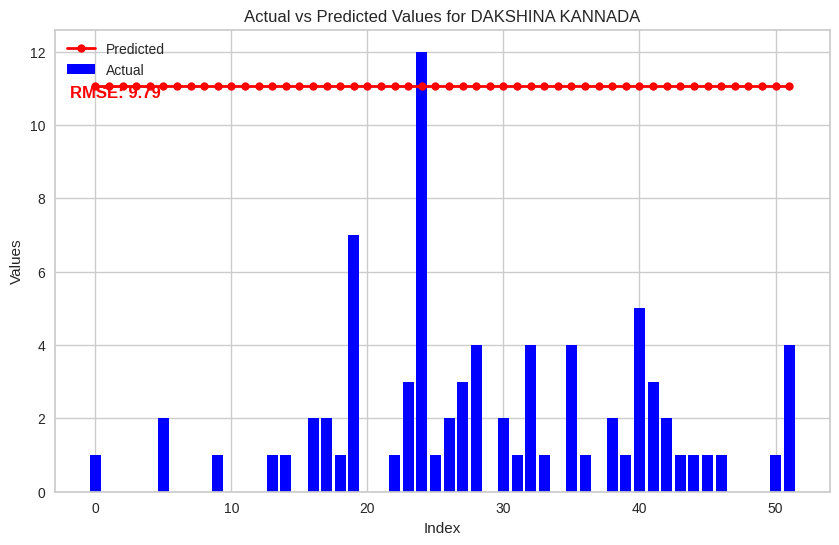

Analyzing District: DAVANGERE


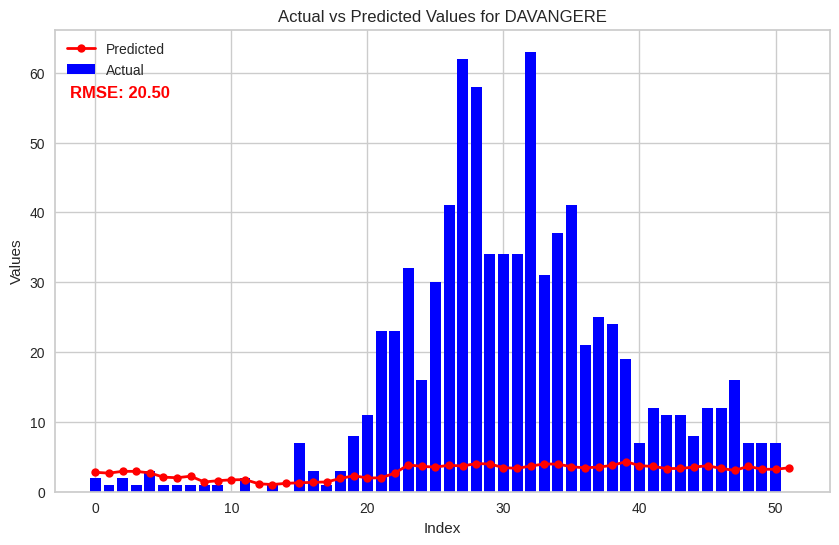

Analyzing District: DHARWAD


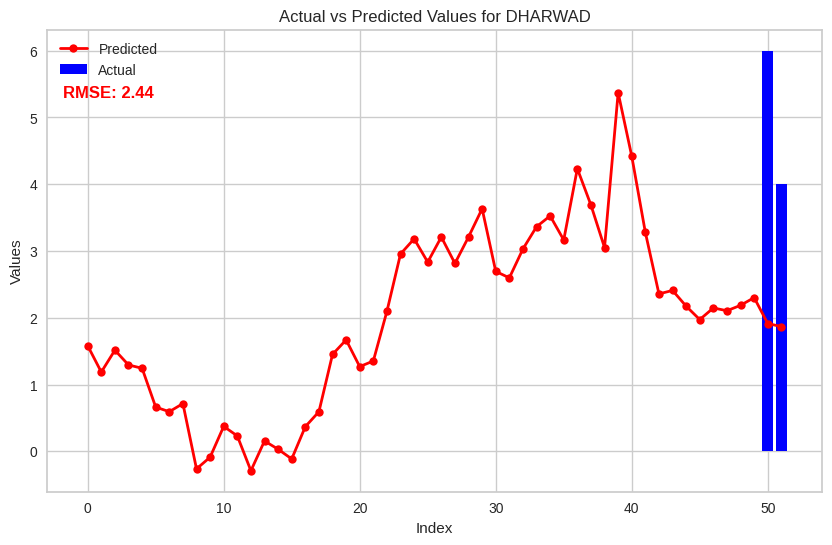

Analyzing District: GADAG


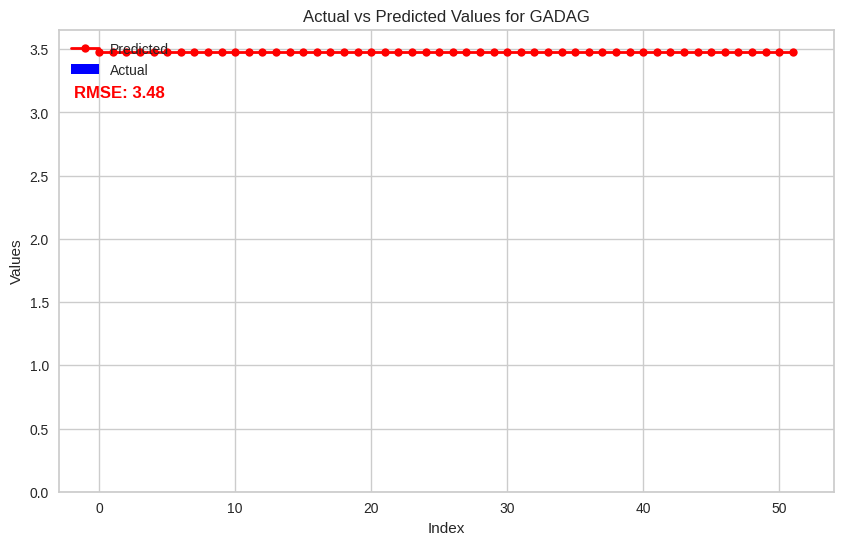

Analyzing District: HASSAN


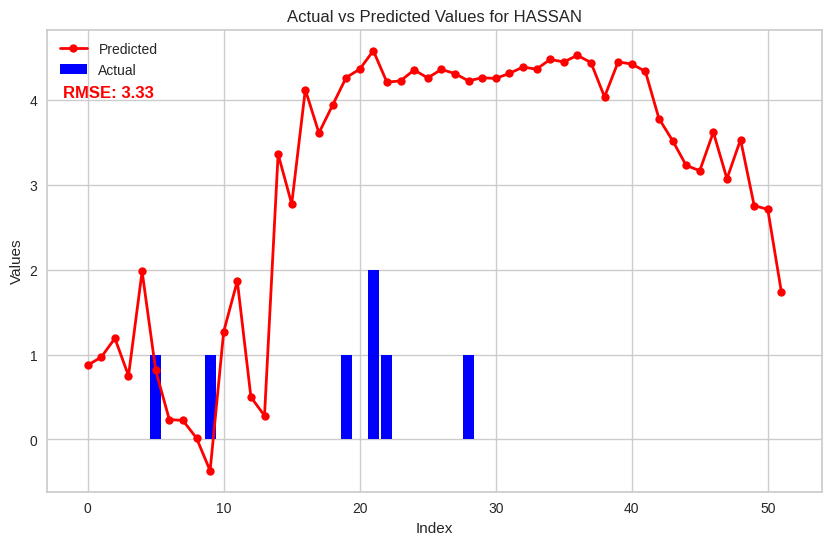

Analyzing District: HAVERI


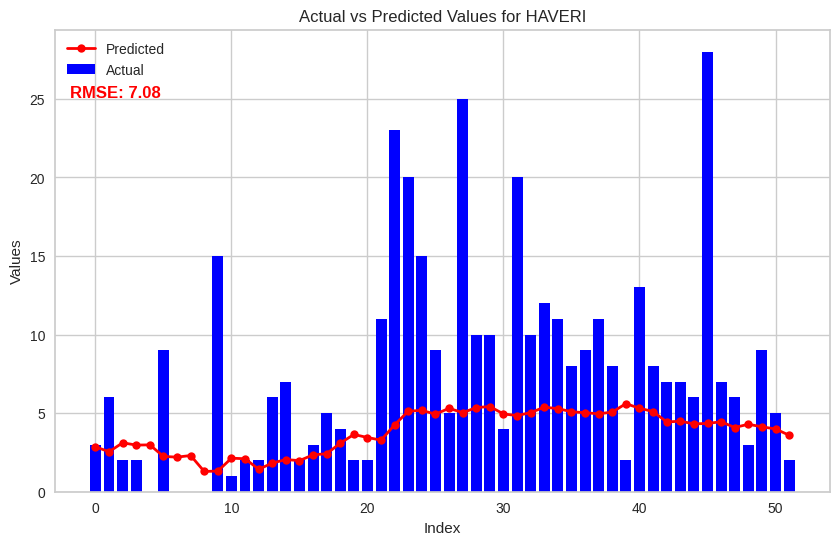

Analyzing District: KALABURAGI


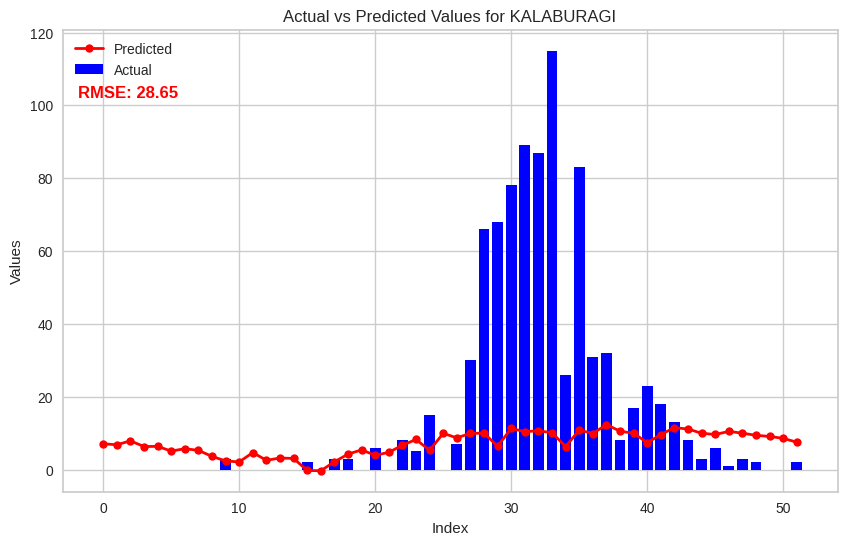

Analyzing District: KODAGU


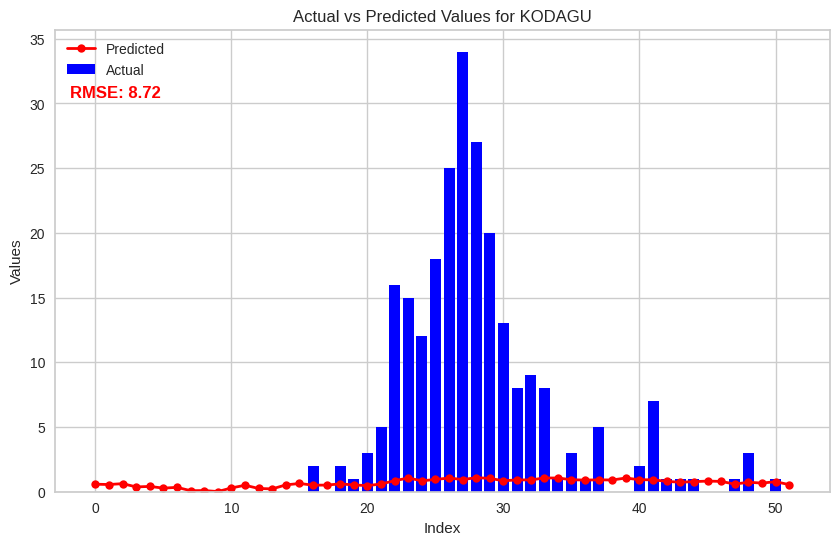

Analyzing District: KOLAR


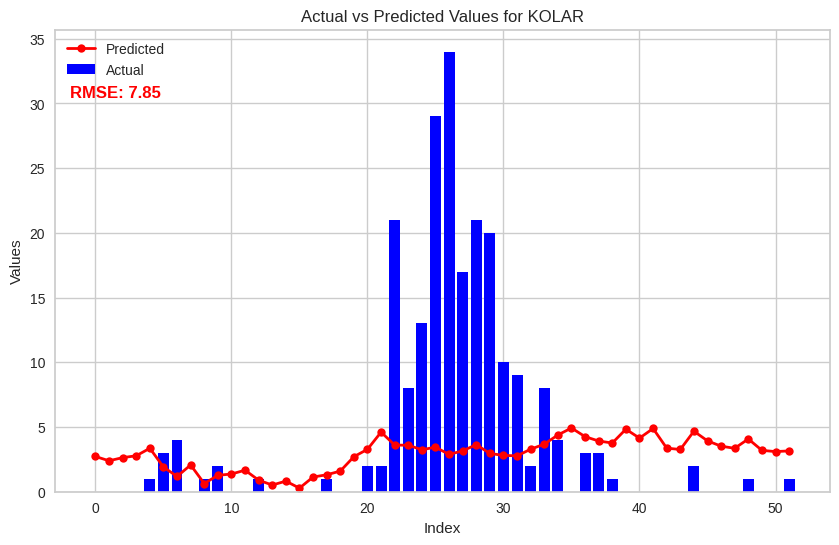

Analyzing District: KOPPAL


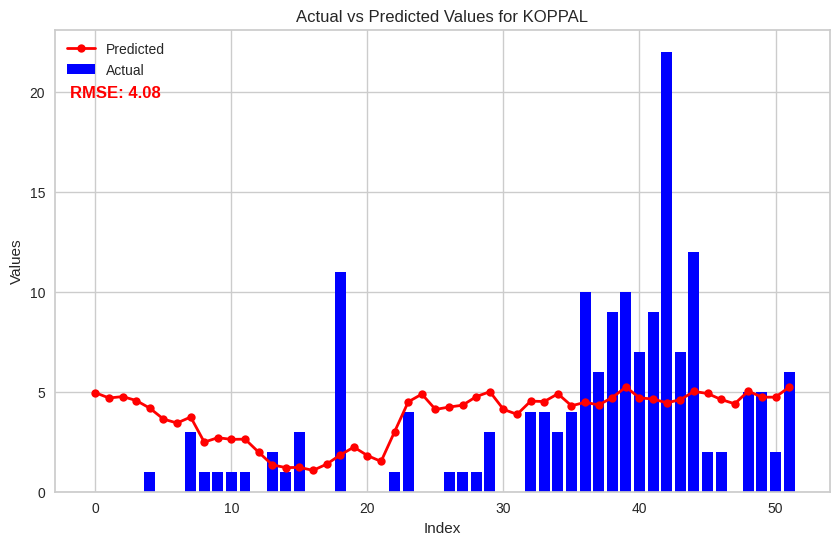

Analyzing District: MANDYA


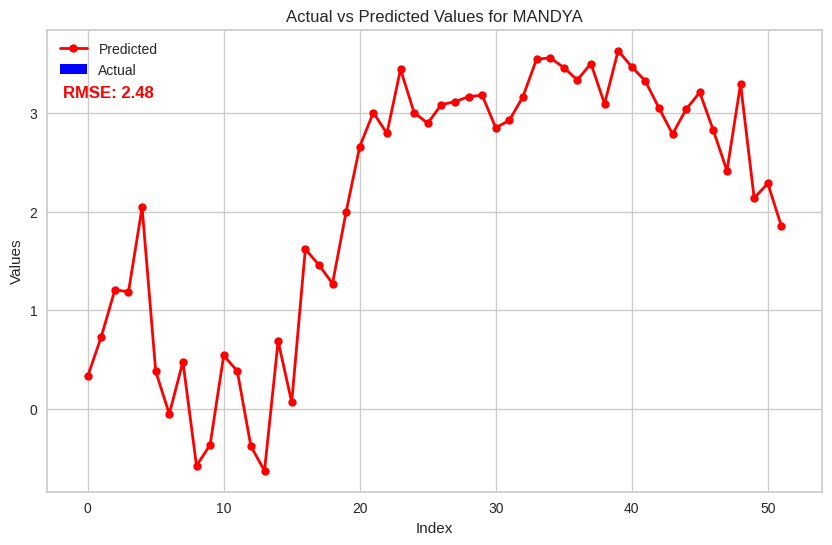

Analyzing District: MYSURU


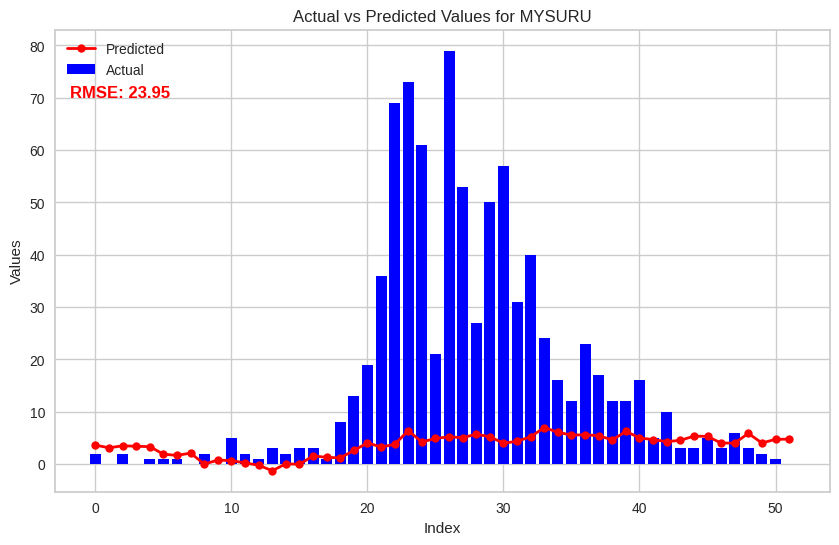

Analyzing District: RAICHUR


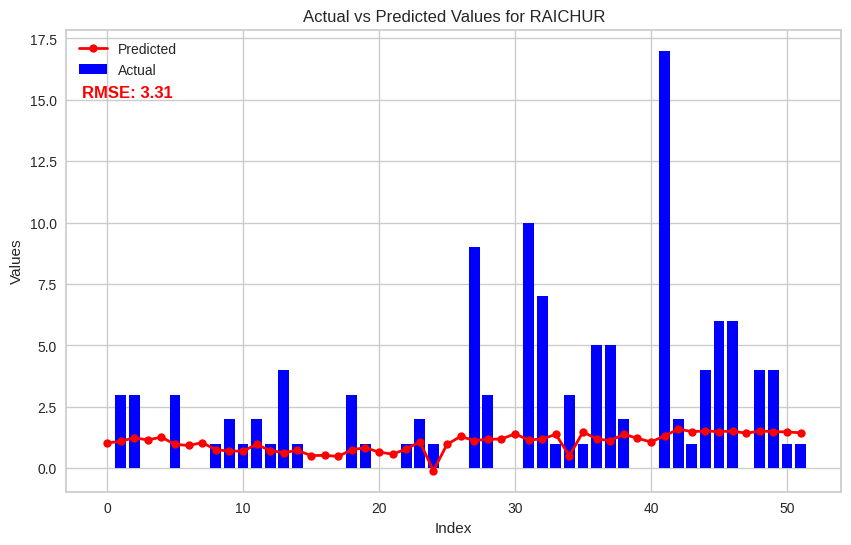

Analyzing District: RAMANAGARA


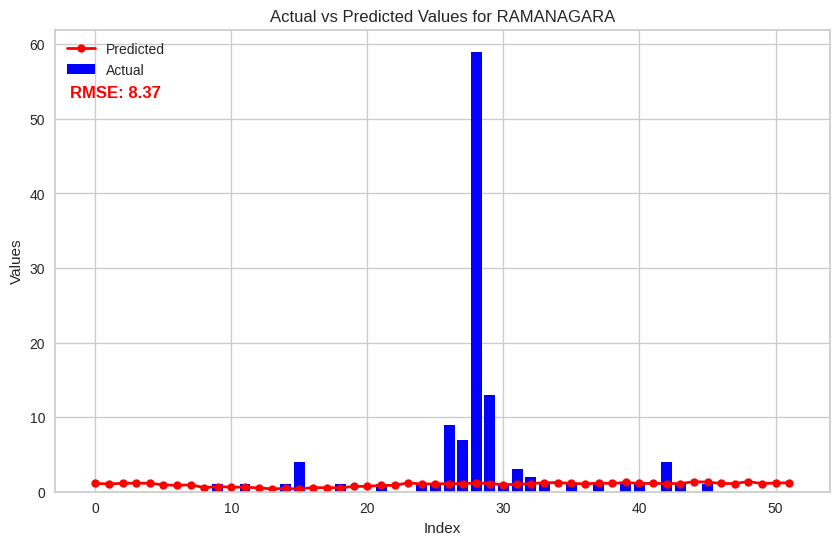

Analyzing District: SHIVAMOGGA


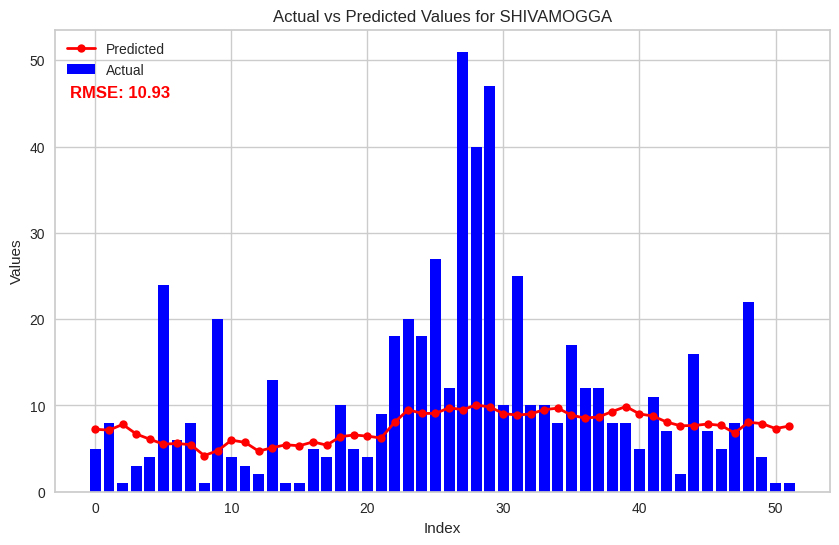

Analyzing District: TUMAKURU


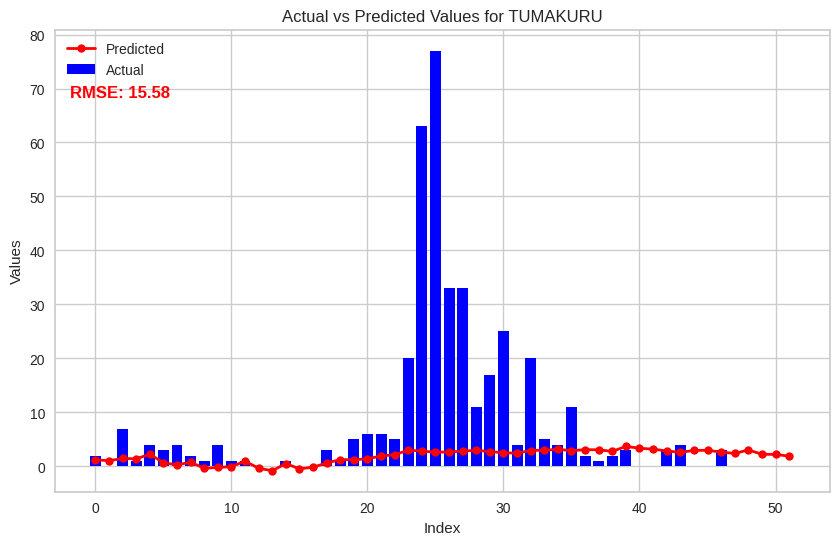

Analyzing District: UDUPI


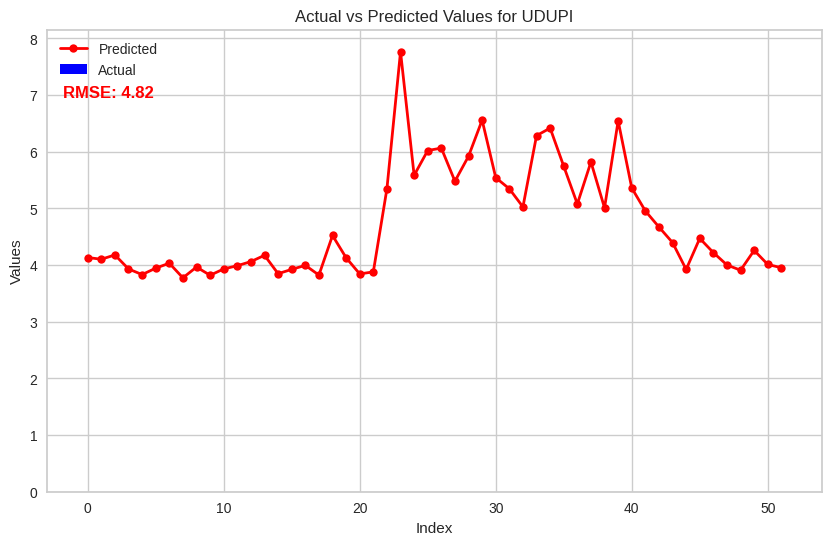

Analyzing District: UTTARA KANNADA


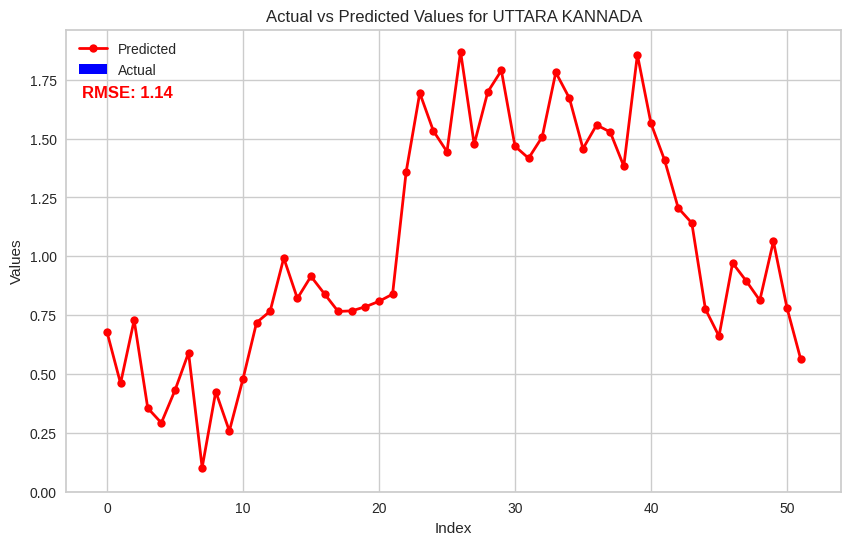

Analyzing District: VIJAYANAGAR


/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

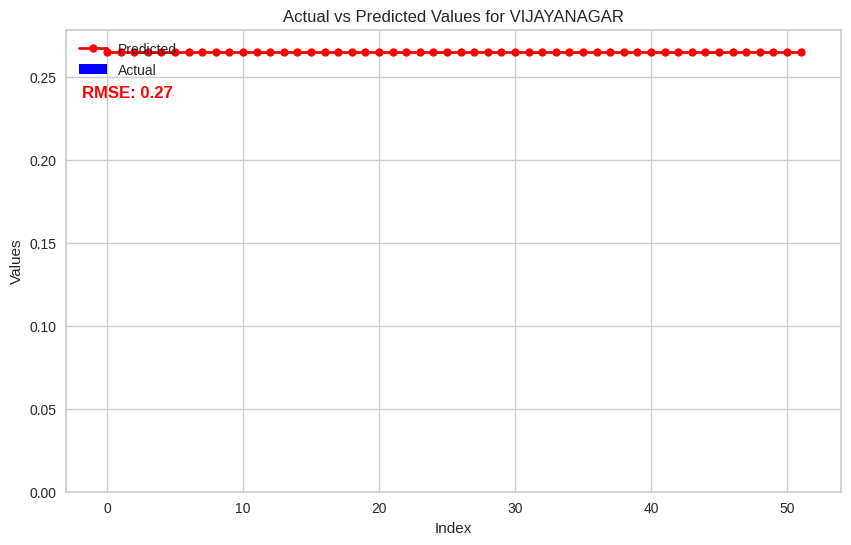

Analyzing District: VIJAYAPURA


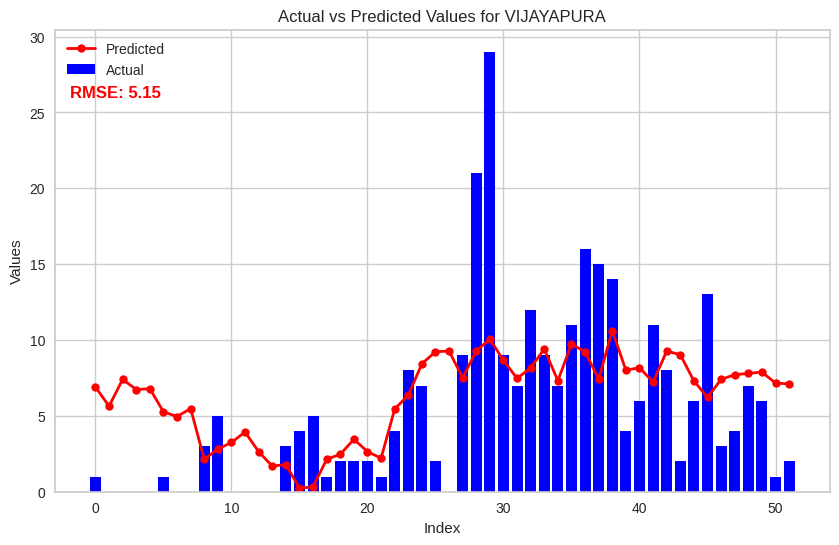

Analyzing District: YADGIR


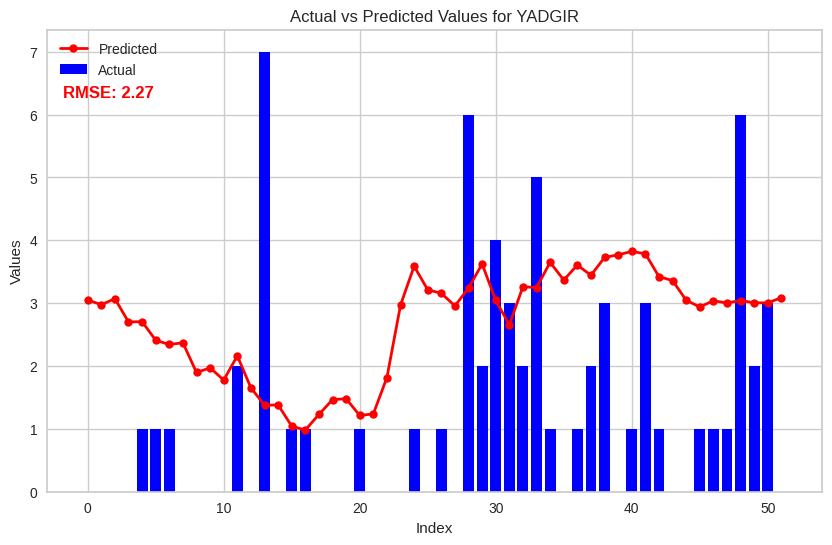

In [26]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2017)
df_2017 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE


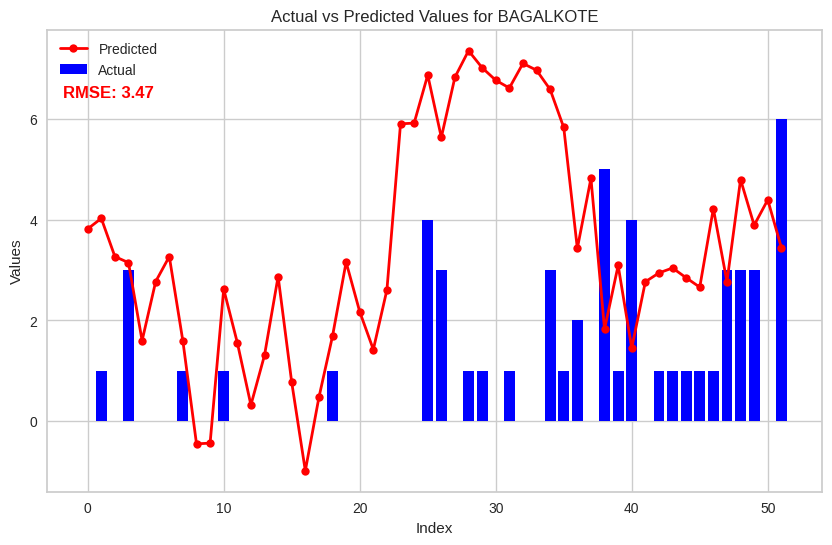

Analyzing District: BALLARI


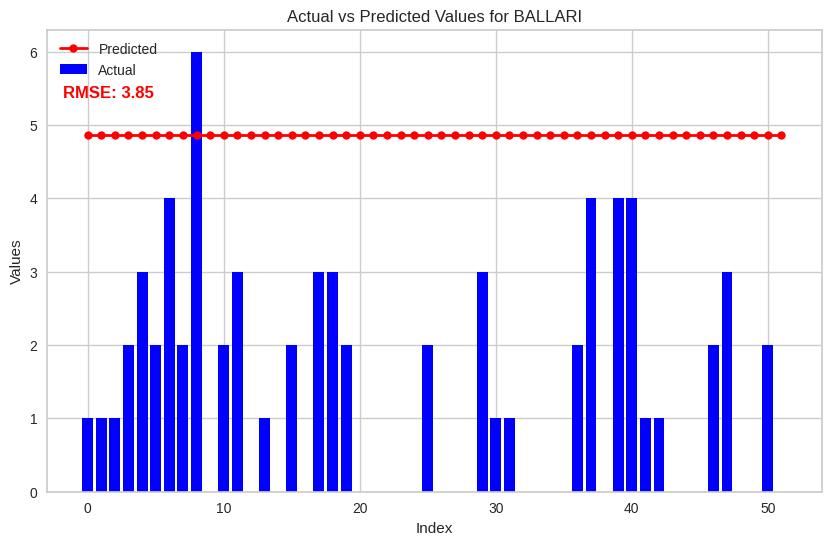

Analyzing District: BELAGAVI


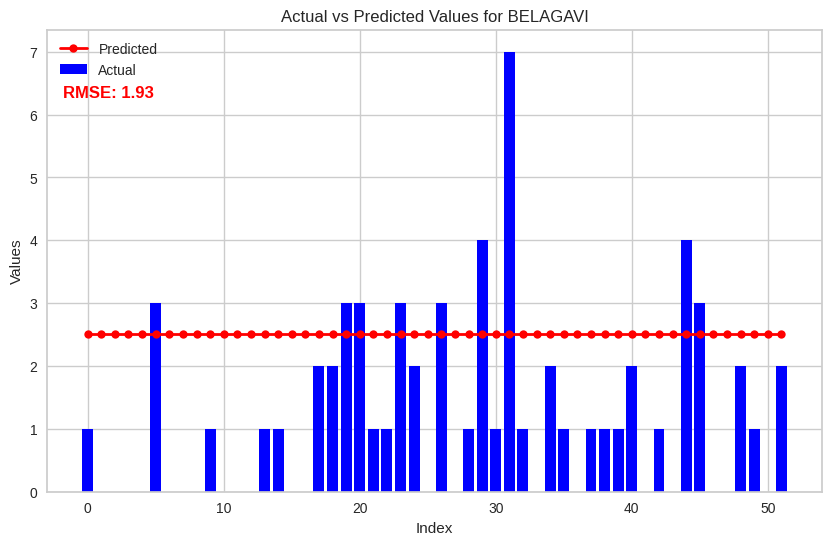

Analyzing District: BENGALURU RURAL


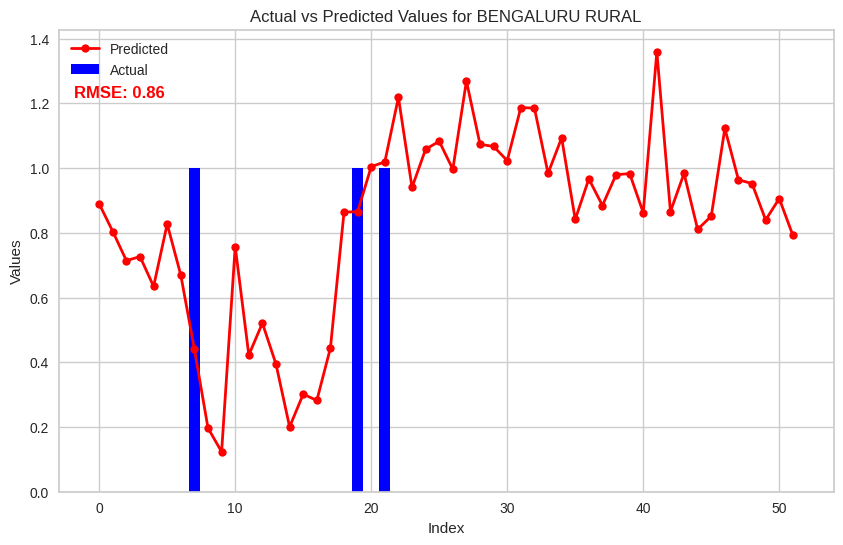

Analyzing District: BENGALURU URBAN


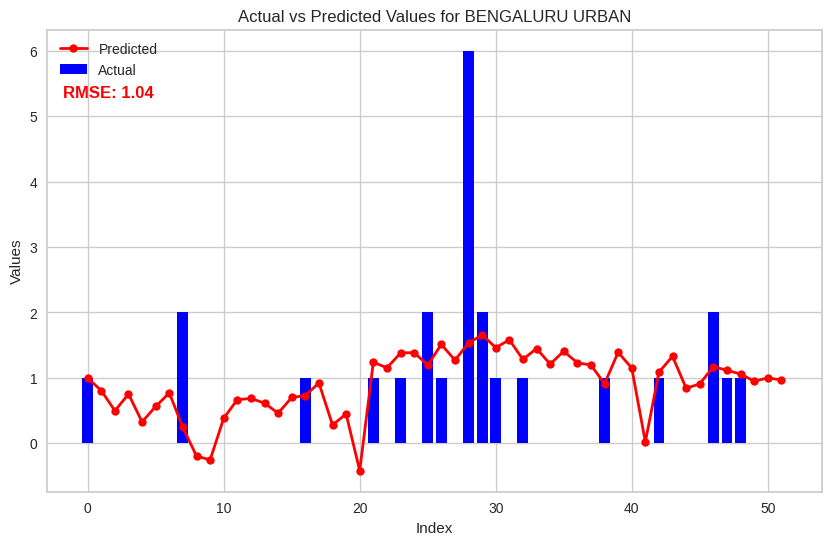

Analyzing District: BIDAR


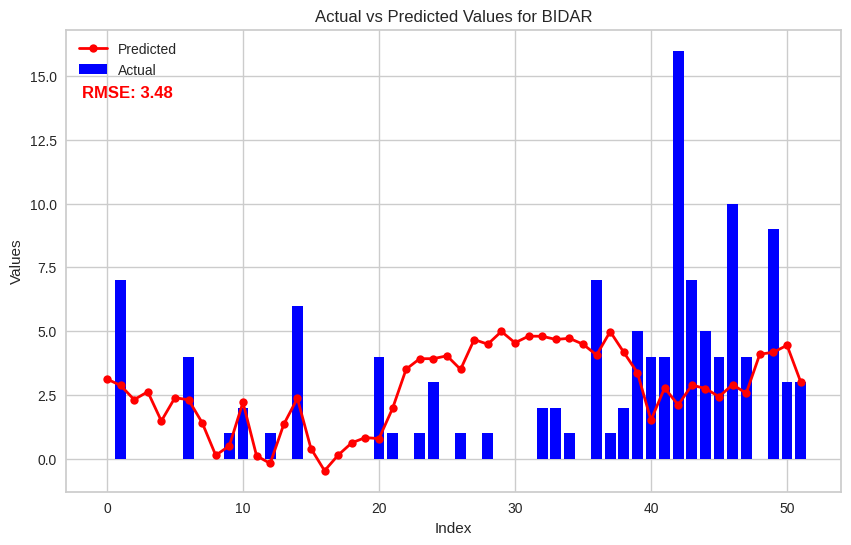

Analyzing District: CHAMARAJANAGARA


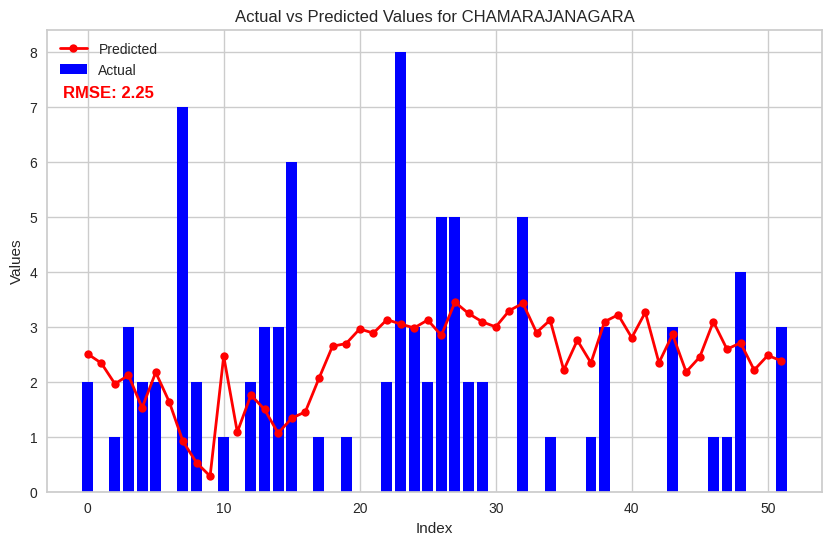

Analyzing District: CHIKKABALLAPURA


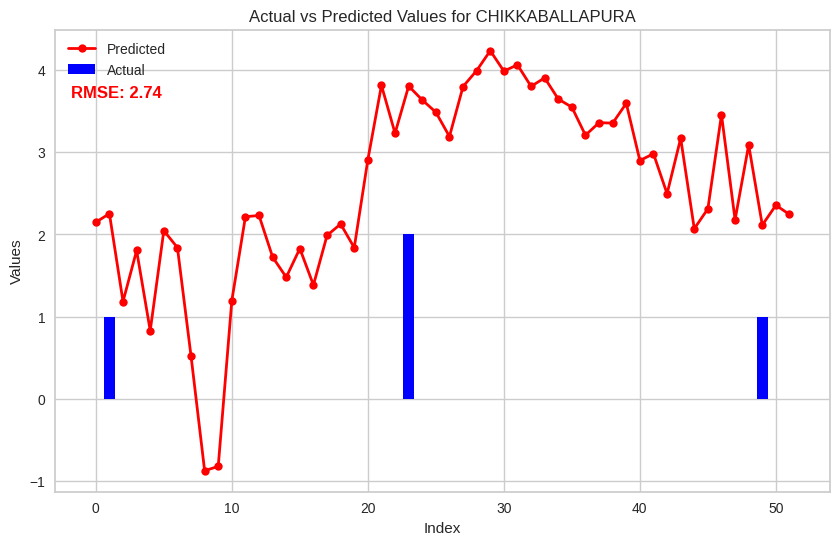

Analyzing District: CHIKKAMAGALURU


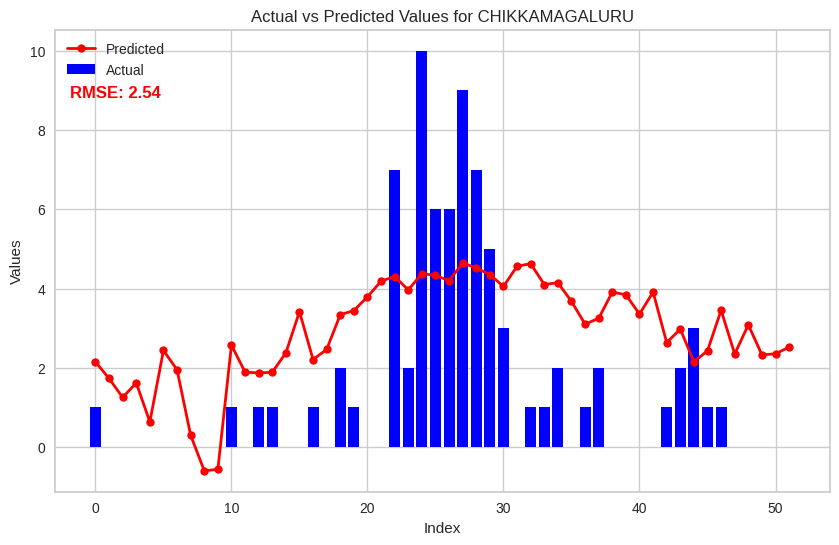

Analyzing District: CHITRADURGA


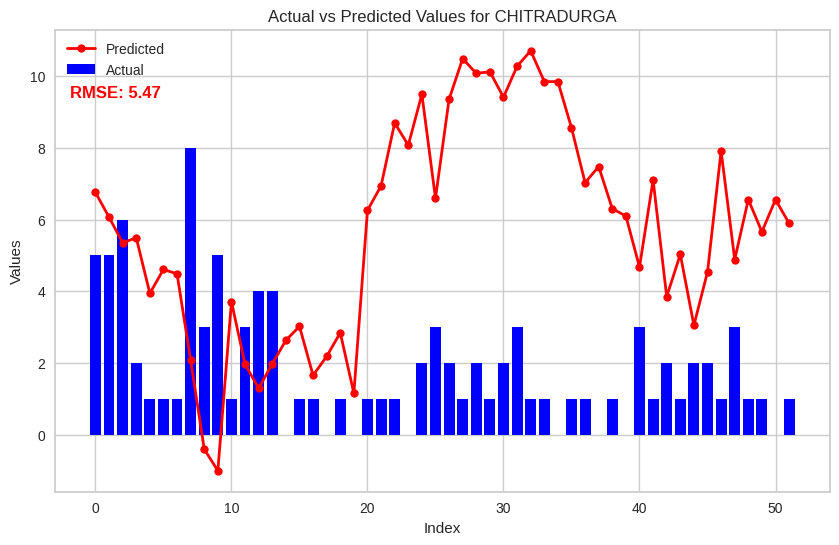

Analyzing District: DAKSHINA KANNADA


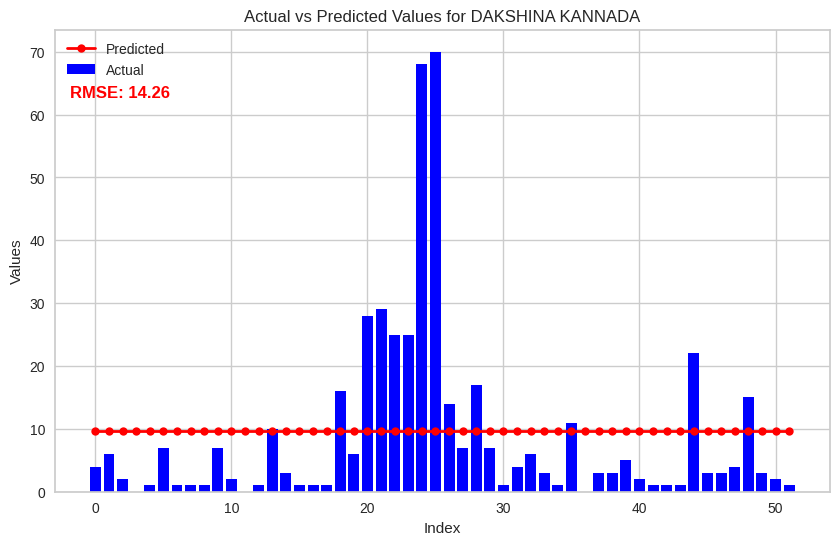

Analyzing District: DAVANGERE


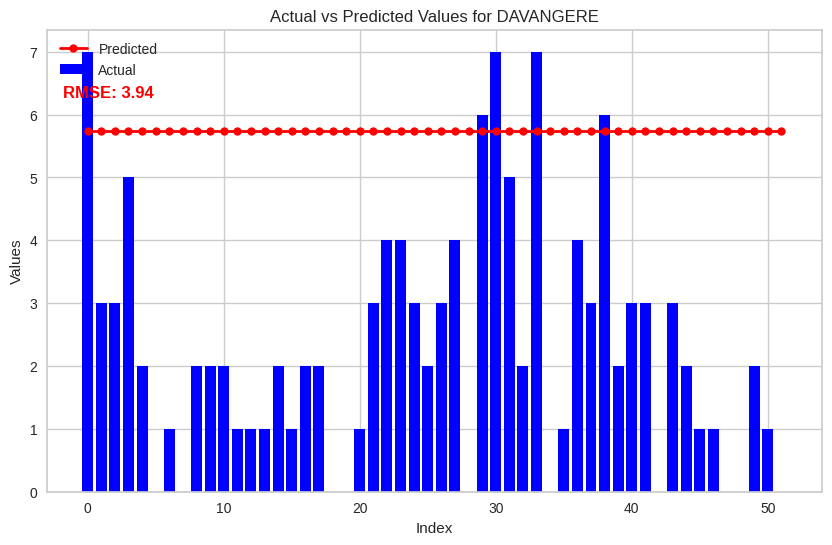

Analyzing District: DHARWAD


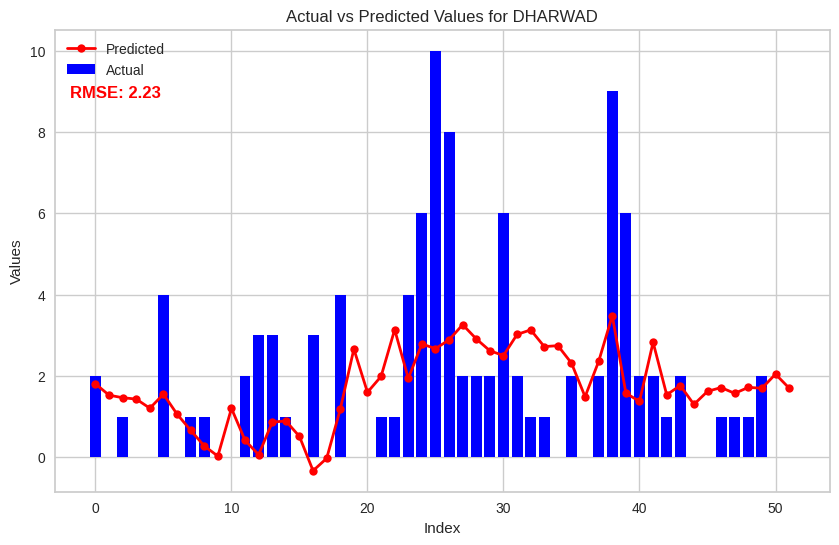

Analyzing District: GADAG


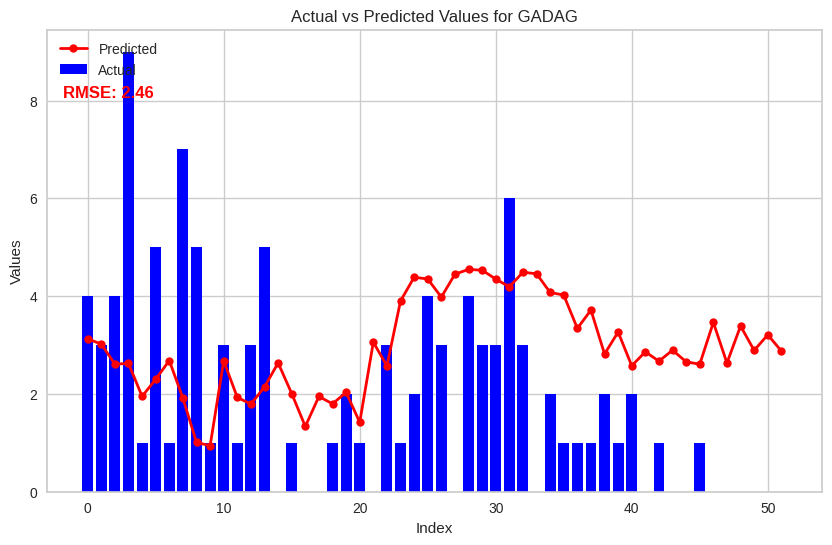

Analyzing District: HASSAN


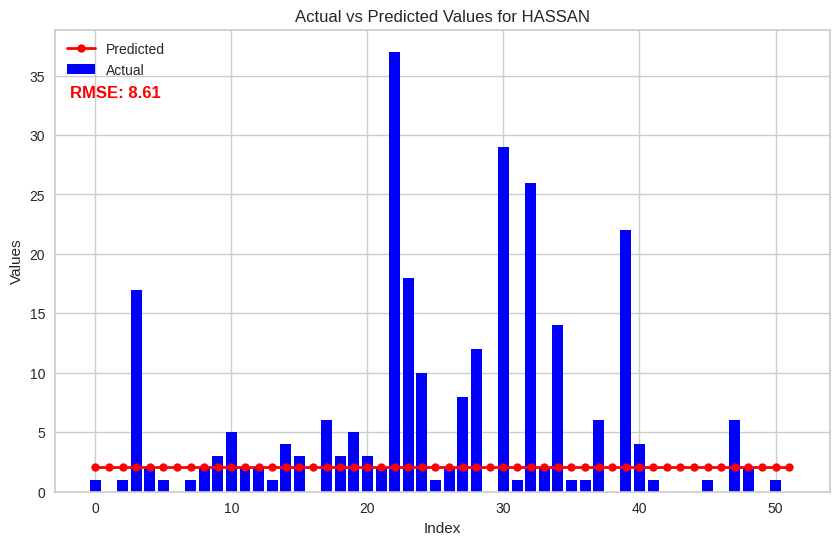

Analyzing District: HAVERI


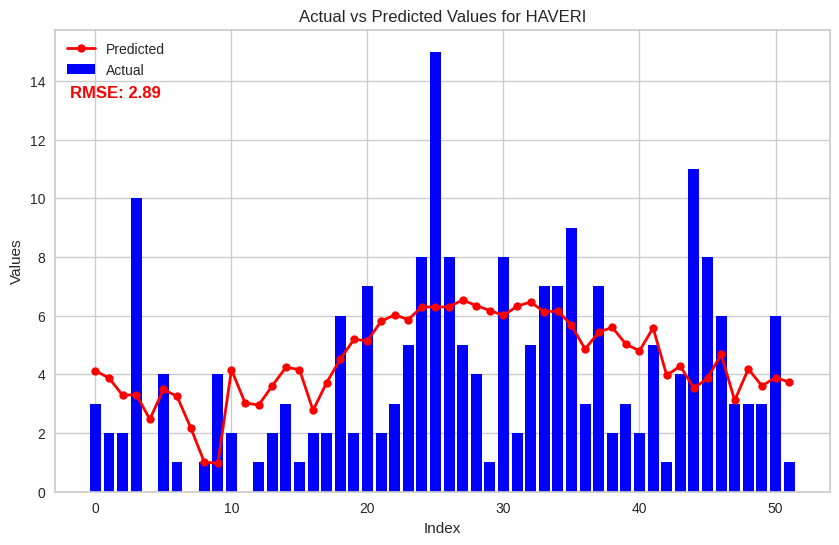

Analyzing District: KALABURAGI


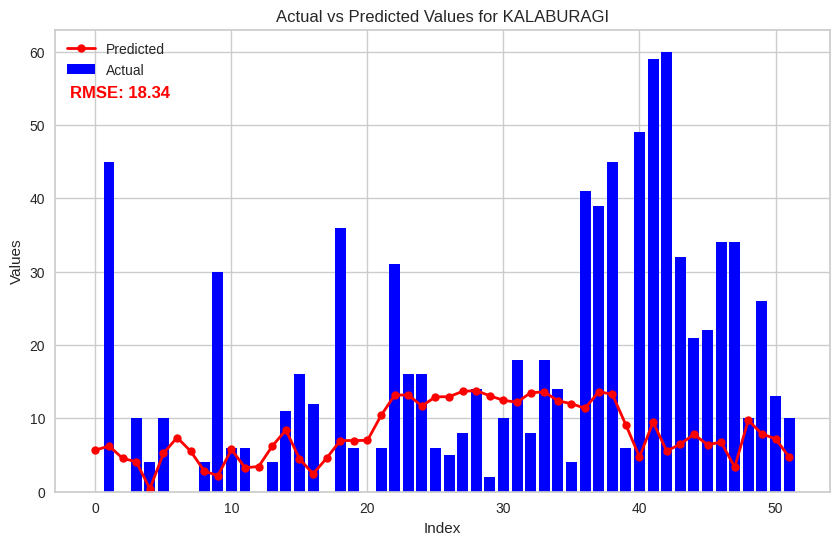

Analyzing District: KODAGU


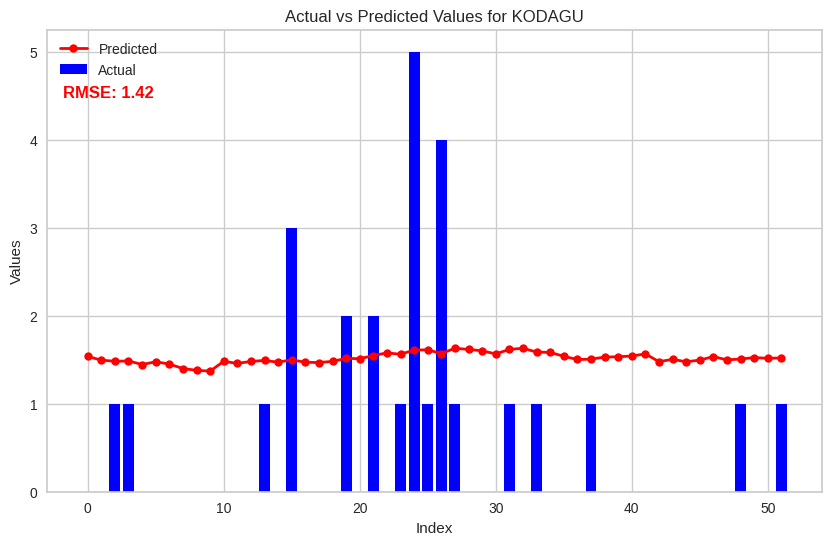

Analyzing District: KOLAR


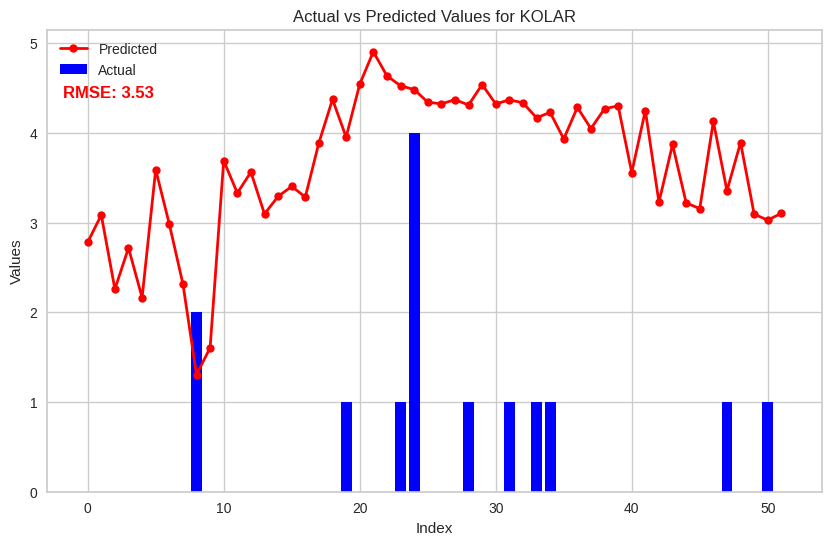

Analyzing District: KOPPAL


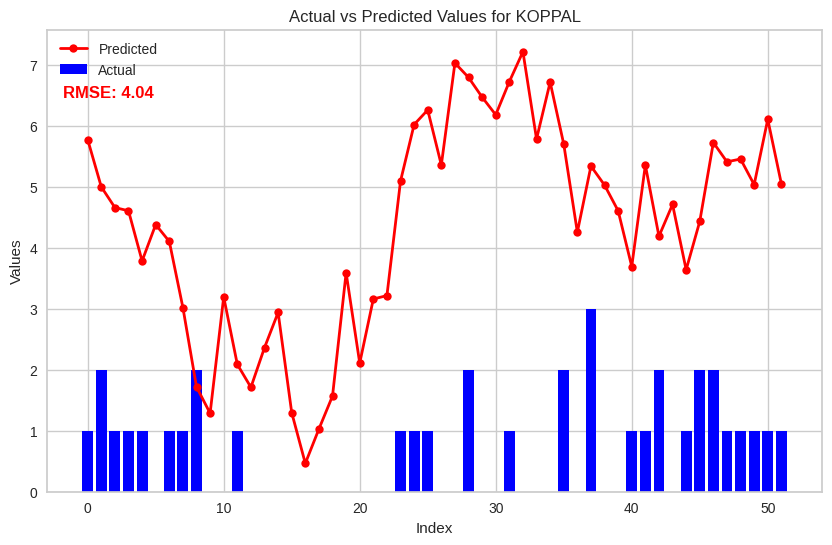

Analyzing District: MANDYA


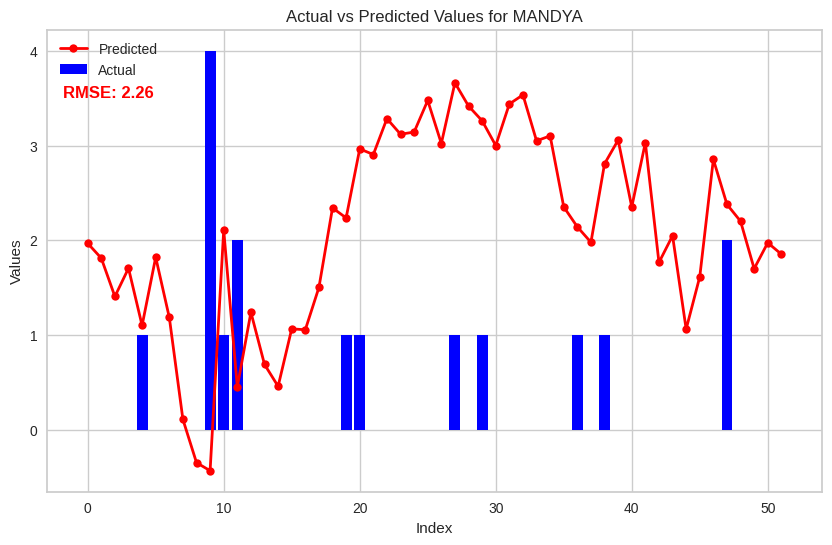

Analyzing District: MYSURU


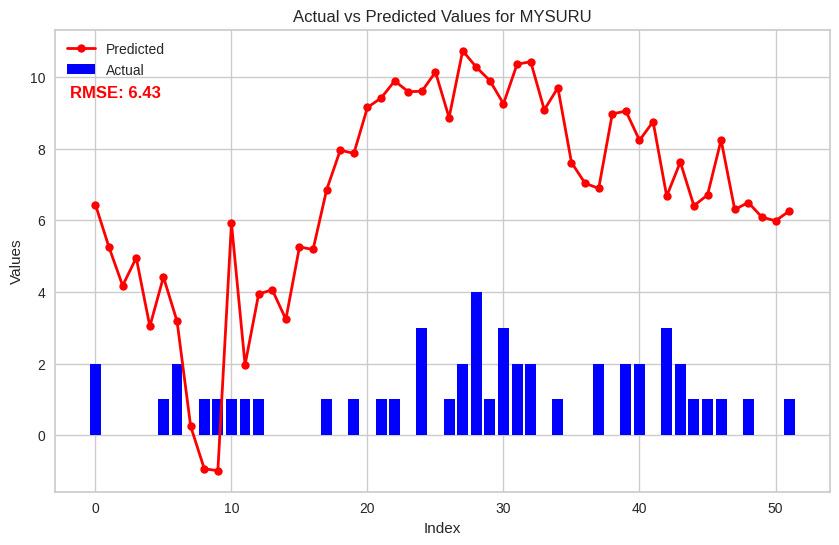

Analyzing District: RAICHUR


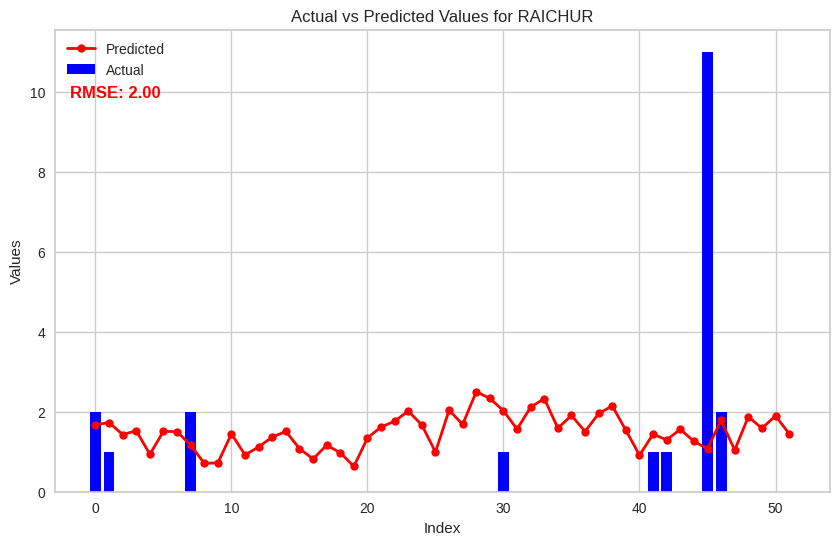

Analyzing District: RAMANAGARA


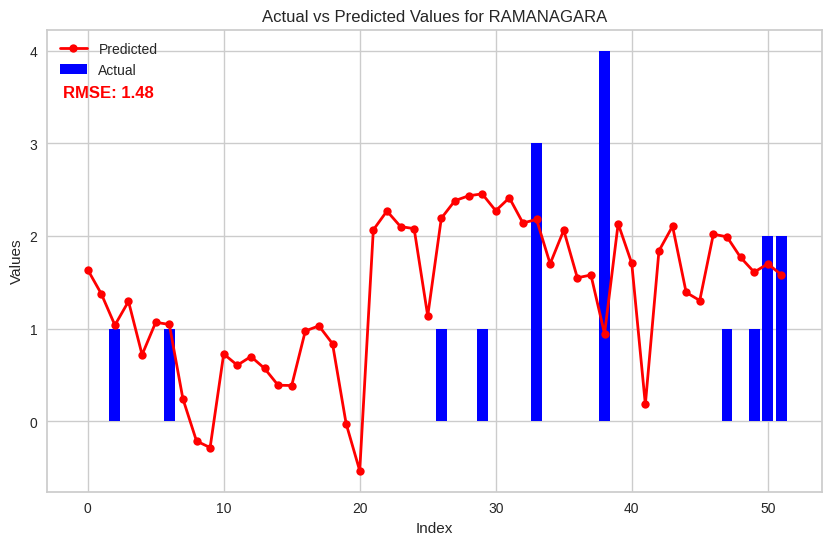

Analyzing District: SHIVAMOGGA


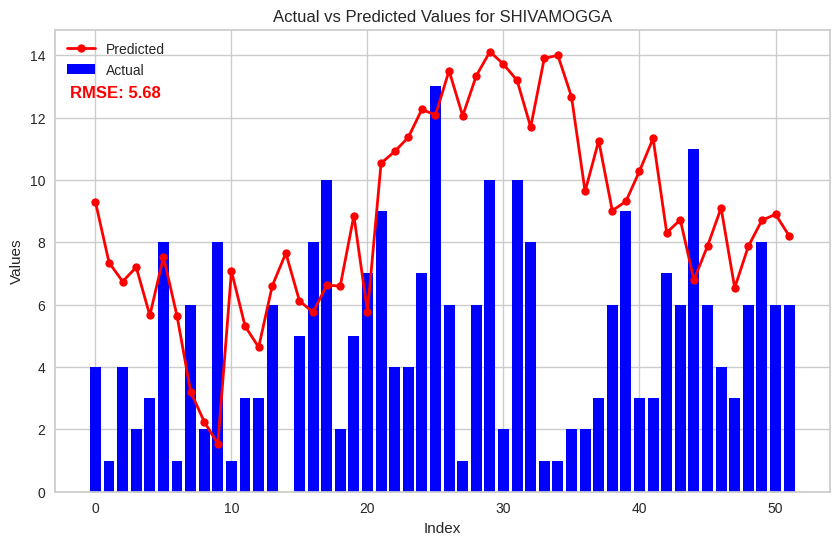

Analyzing District: TUMAKURU


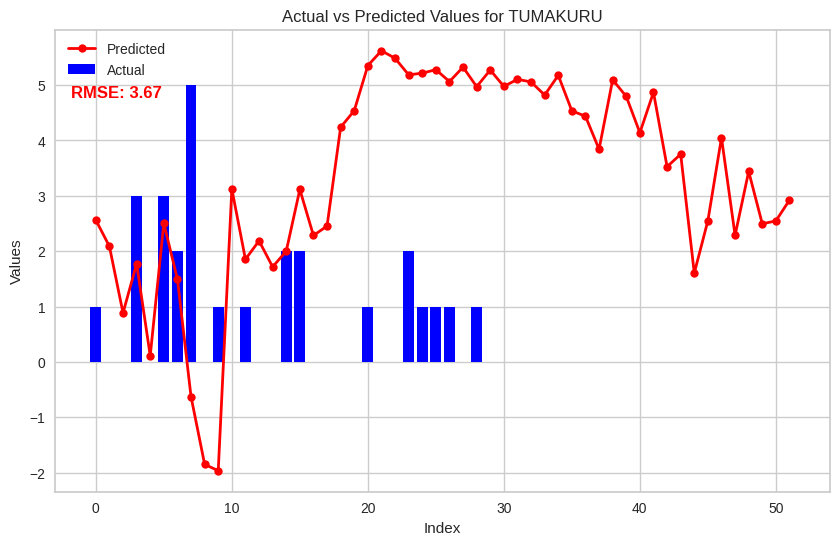

Analyzing District: UDUPI


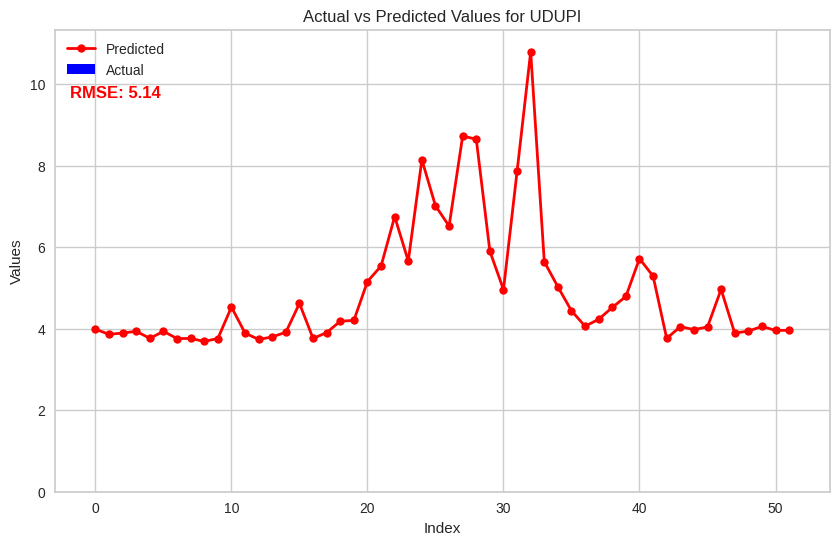

Analyzing District: UTTARA KANNADA


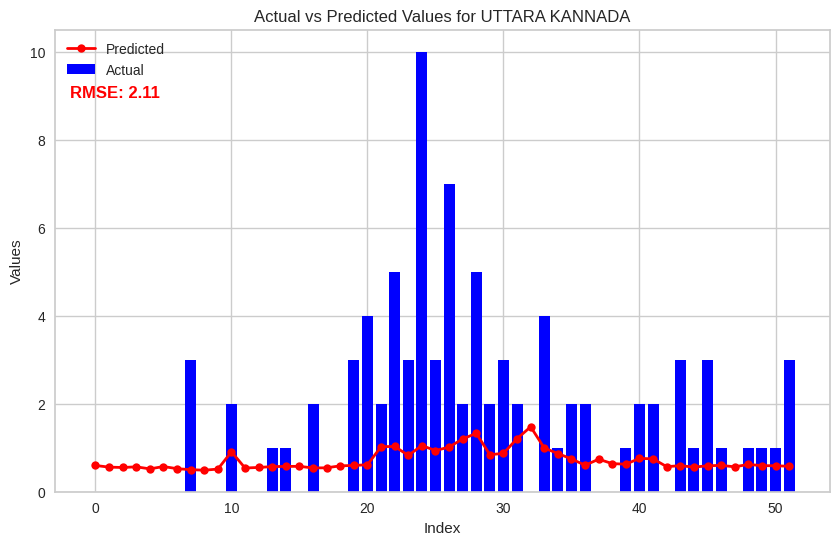

Analyzing District: VIJAYANAGAR


/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

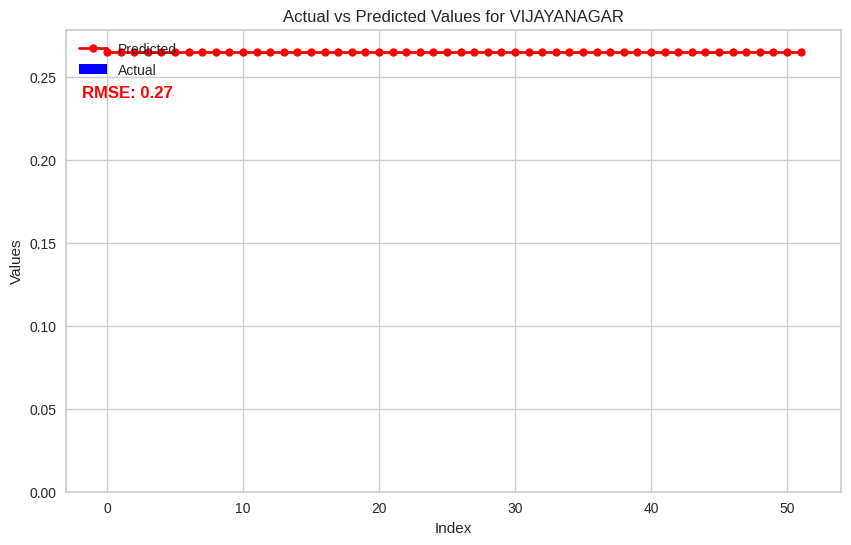

Analyzing District: VIJAYAPURA


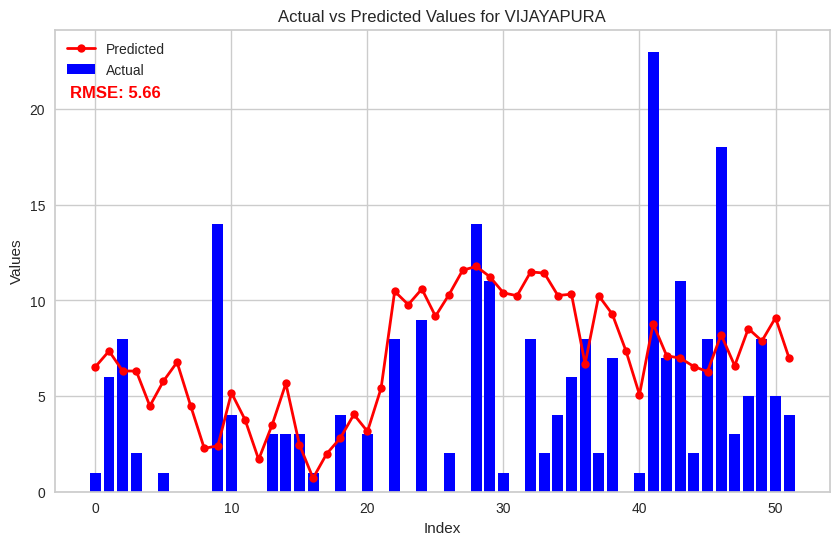

Analyzing District: YADGIR


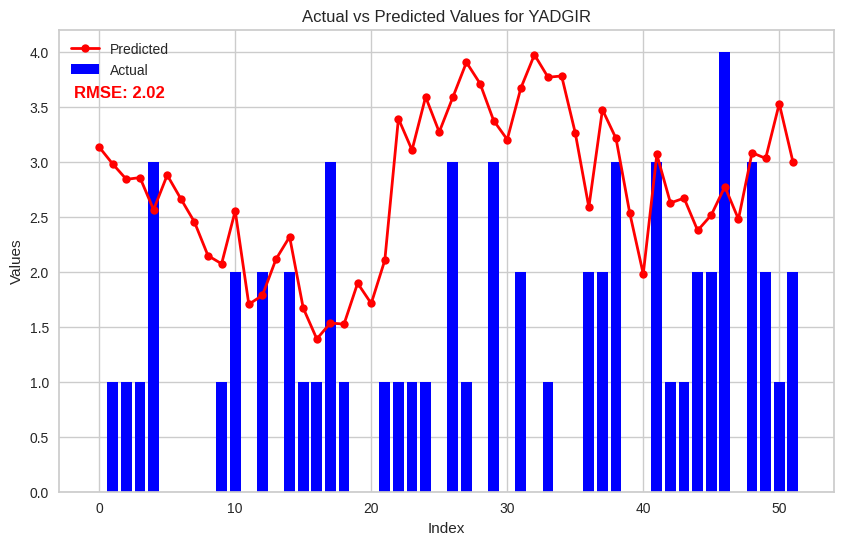

In [27]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2018)
df_2018 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE


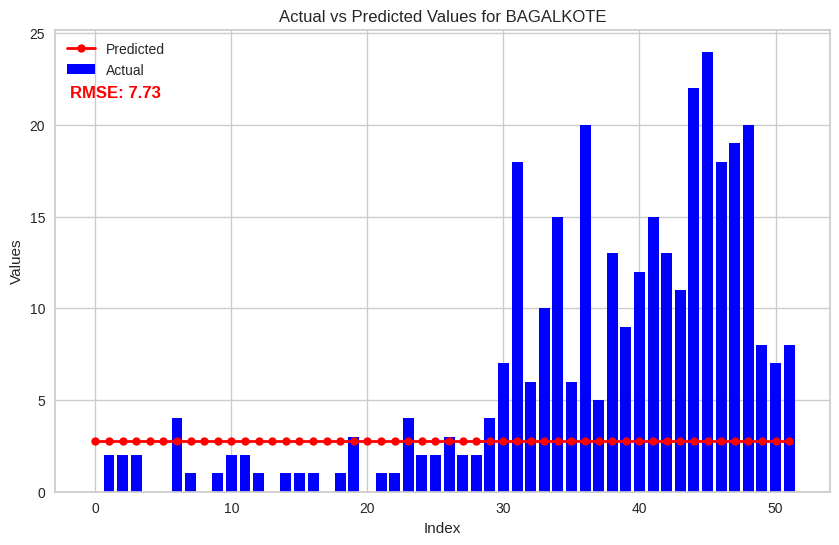

Analyzing District: BALLARI


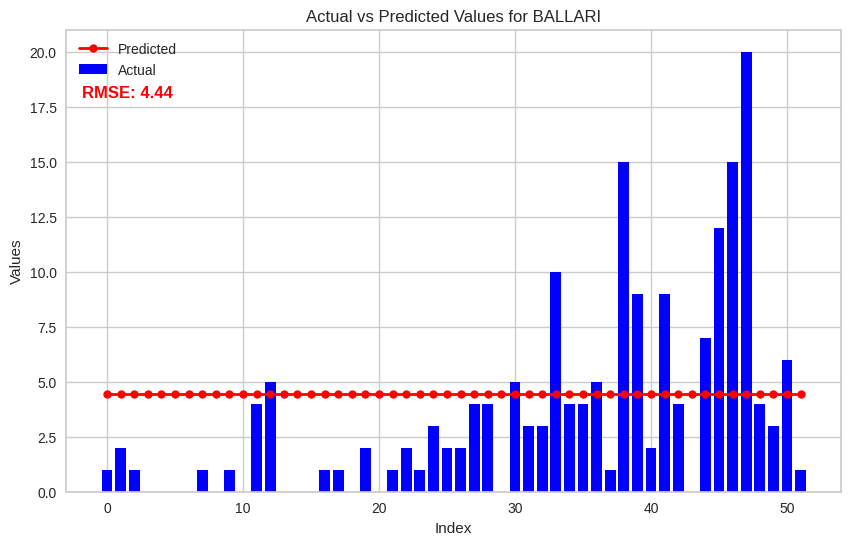

Analyzing District: BELAGAVI


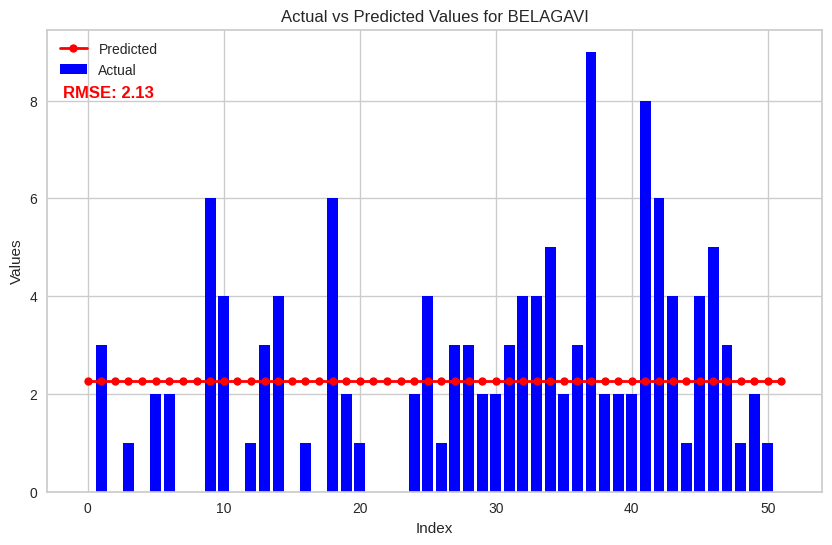

Analyzing District: BENGALURU RURAL


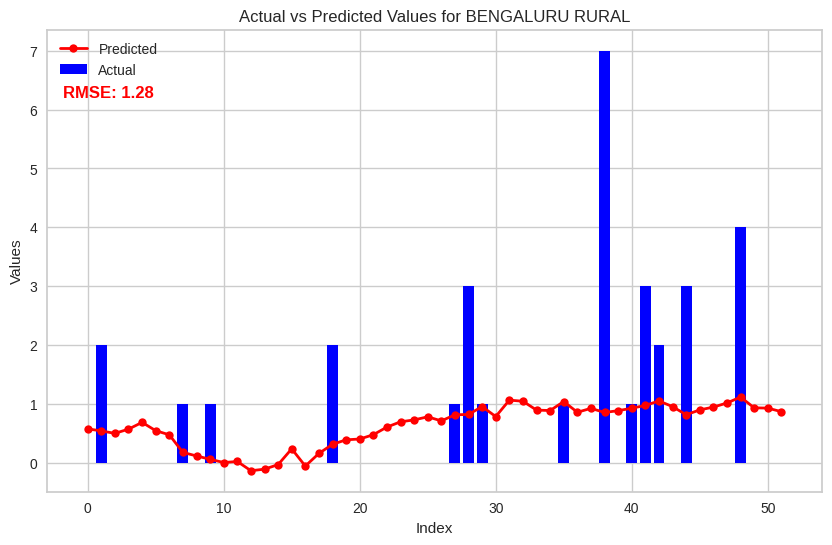

Analyzing District: BENGALURU URBAN


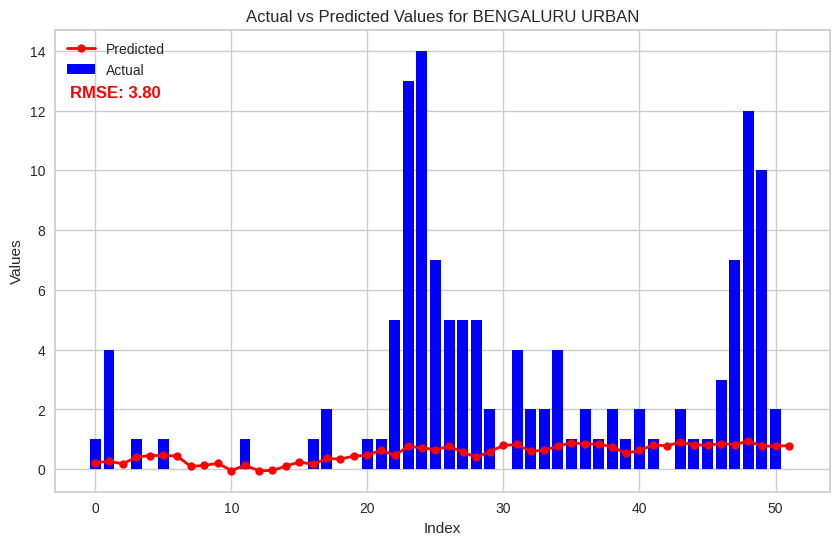

Analyzing District: BIDAR


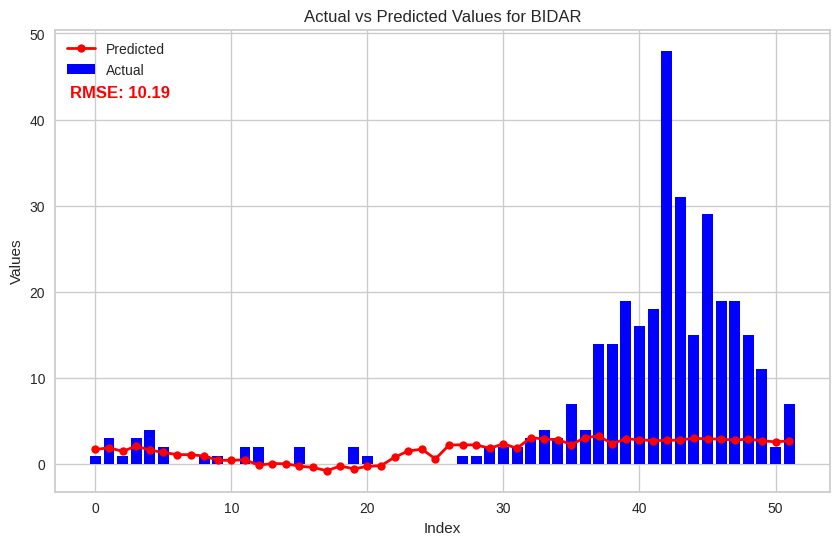

Analyzing District: CHAMARAJANAGARA


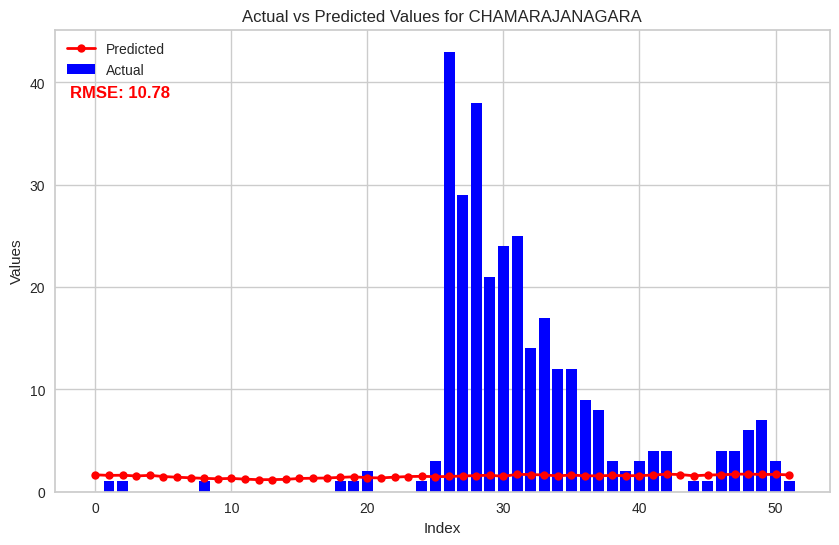

Analyzing District: CHIKKABALLAPURA


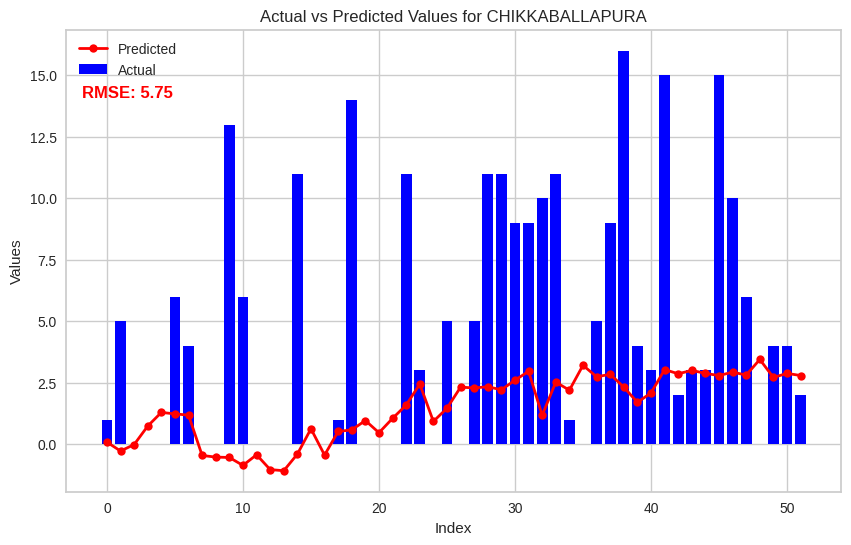

Analyzing District: CHIKKAMAGALURU


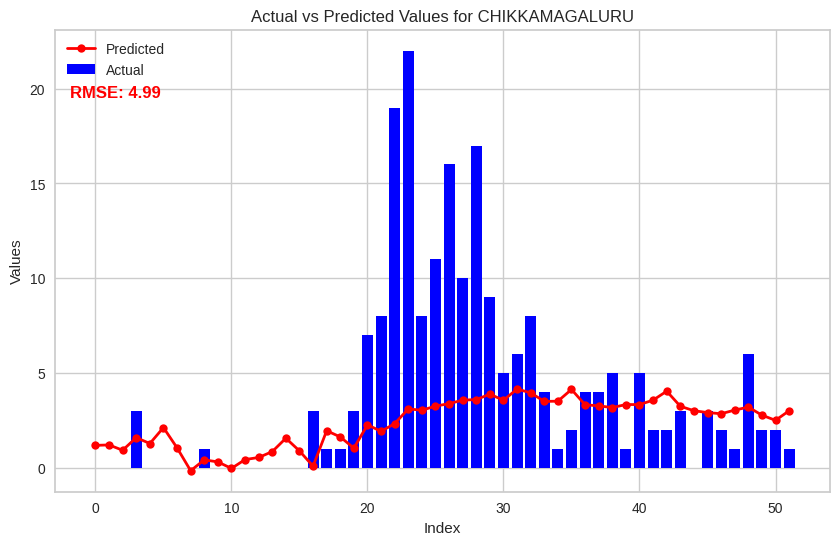

Analyzing District: CHITRADURGA


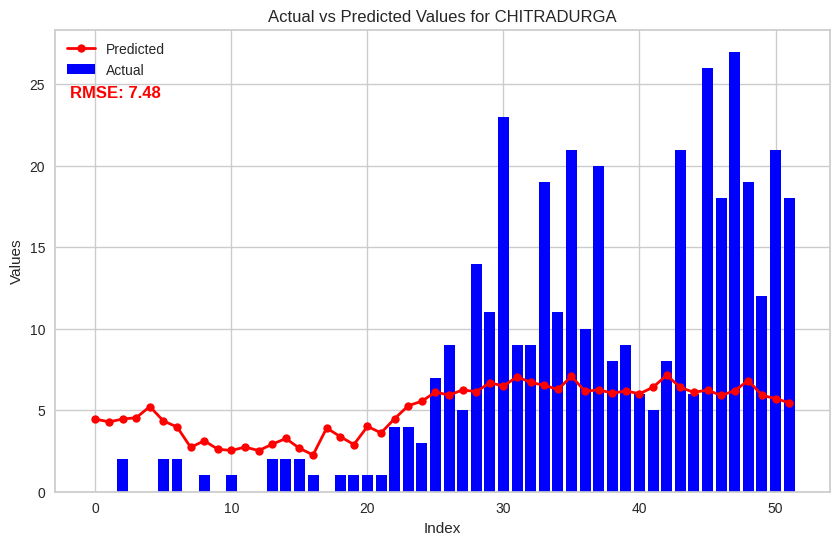

Analyzing District: DAKSHINA KANNADA


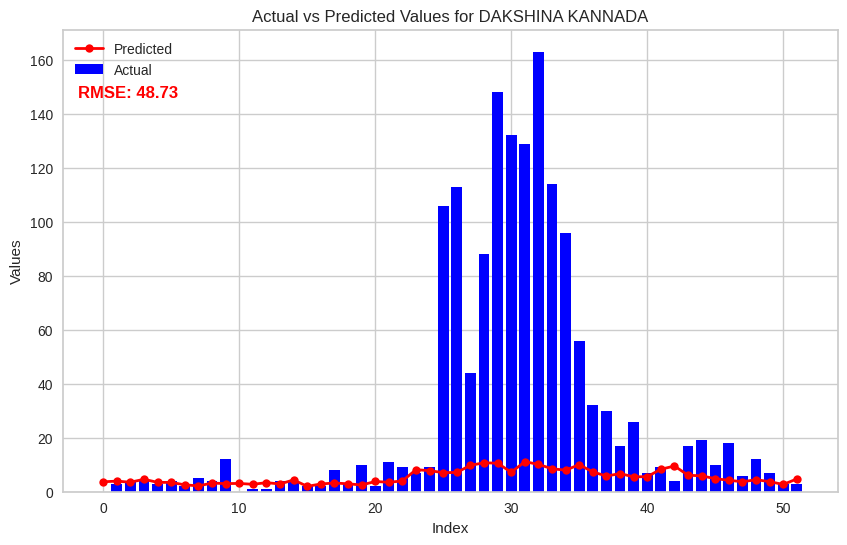

Analyzing District: DAVANGERE


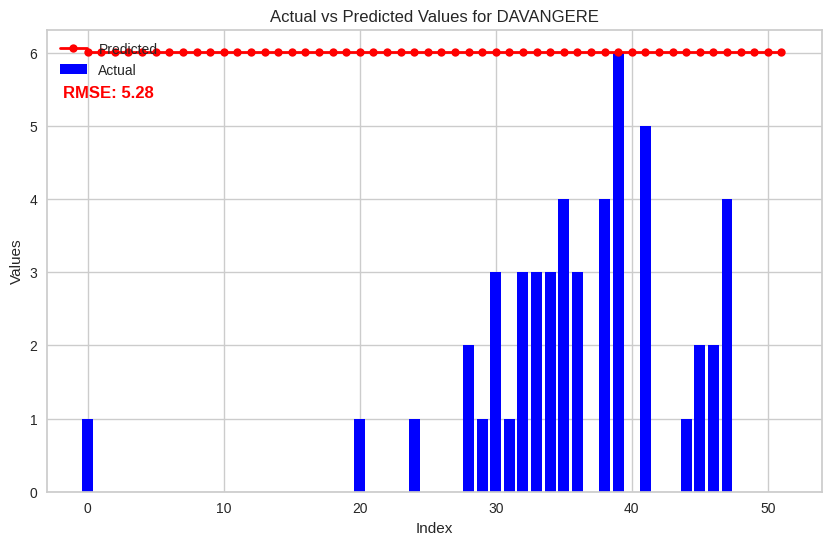

Analyzing District: DHARWAD


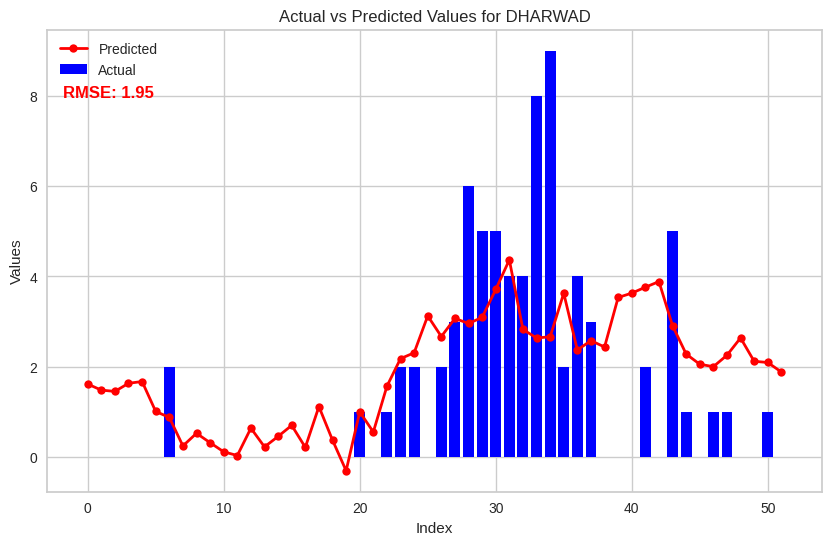

Analyzing District: GADAG


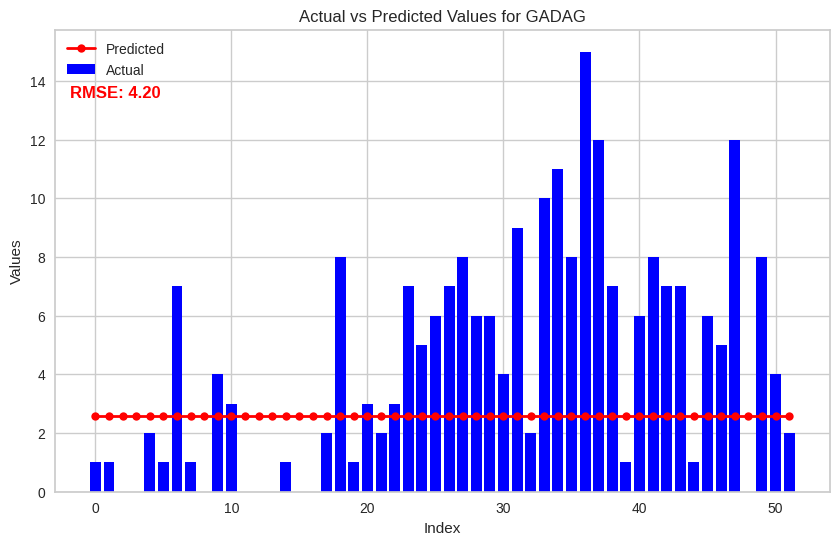

Analyzing District: HASSAN


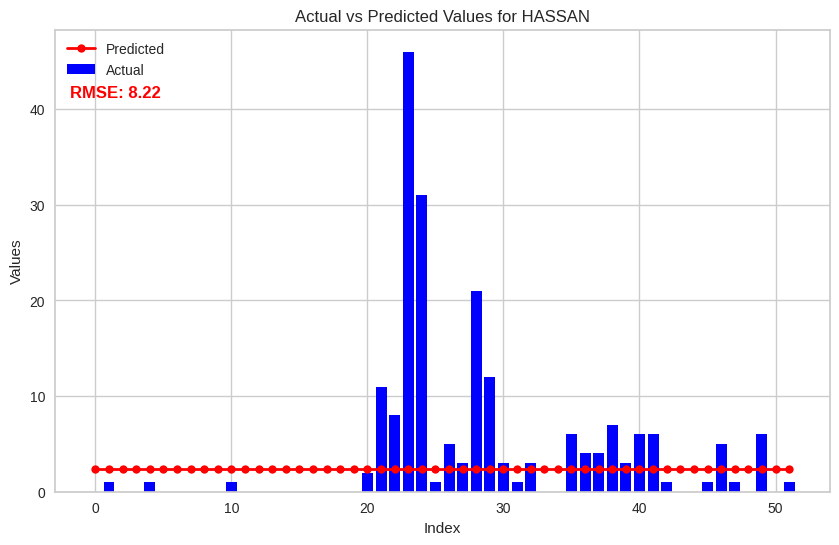

Analyzing District: HAVERI


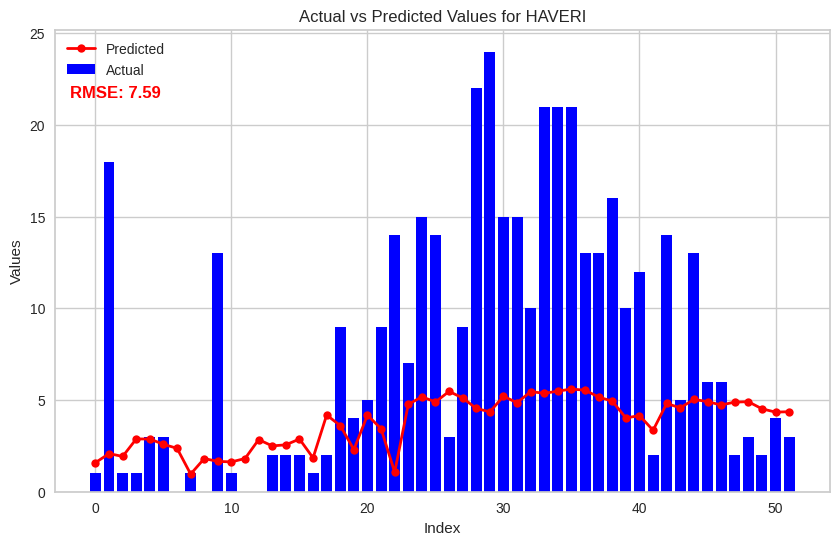

Analyzing District: KALABURAGI


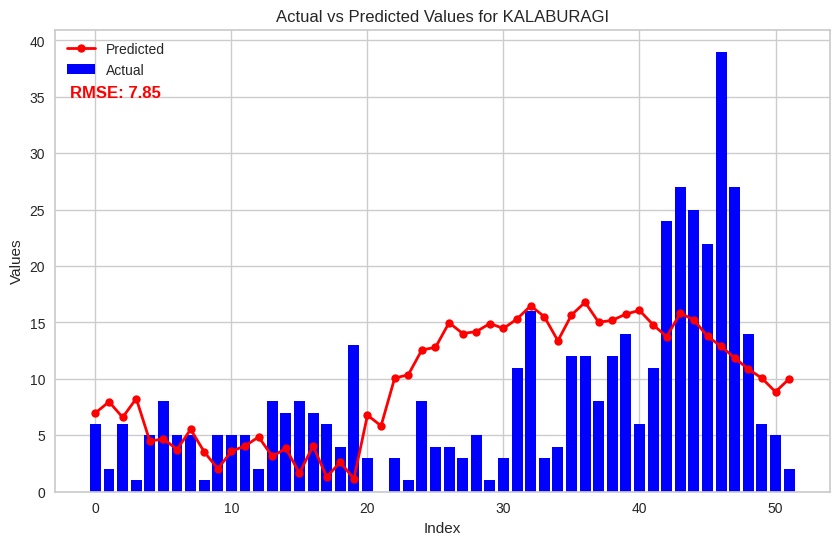

Analyzing District: KODAGU


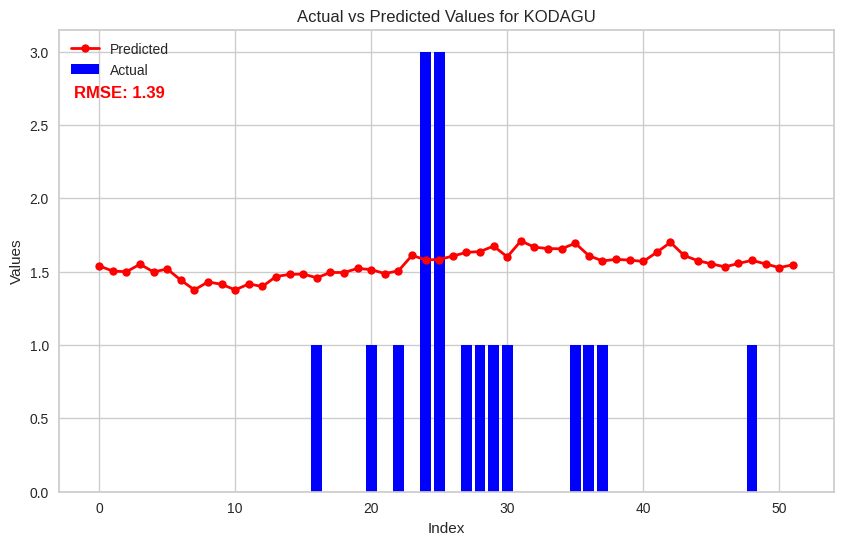

Analyzing District: KOLAR


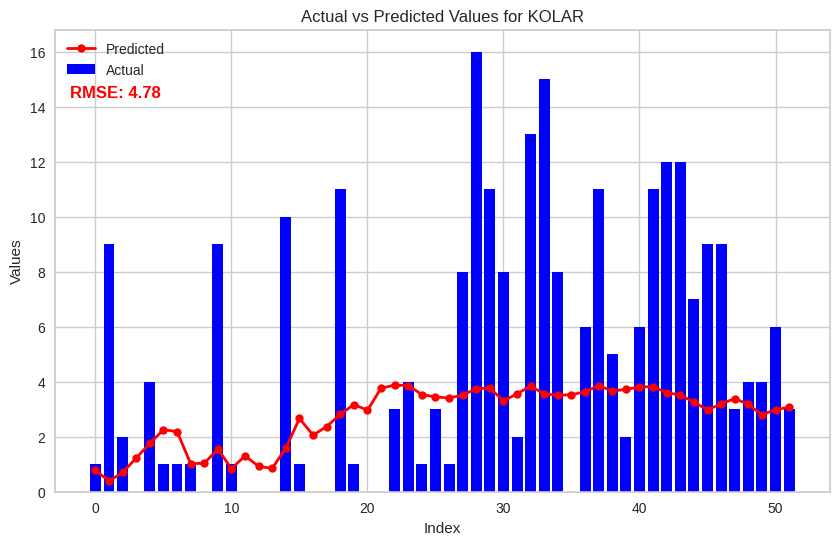

Analyzing District: KOPPAL


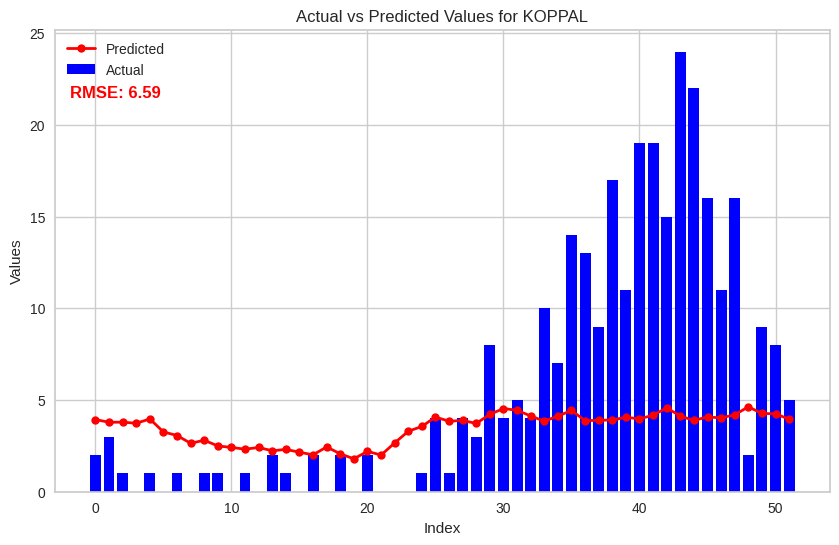

Analyzing District: MANDYA


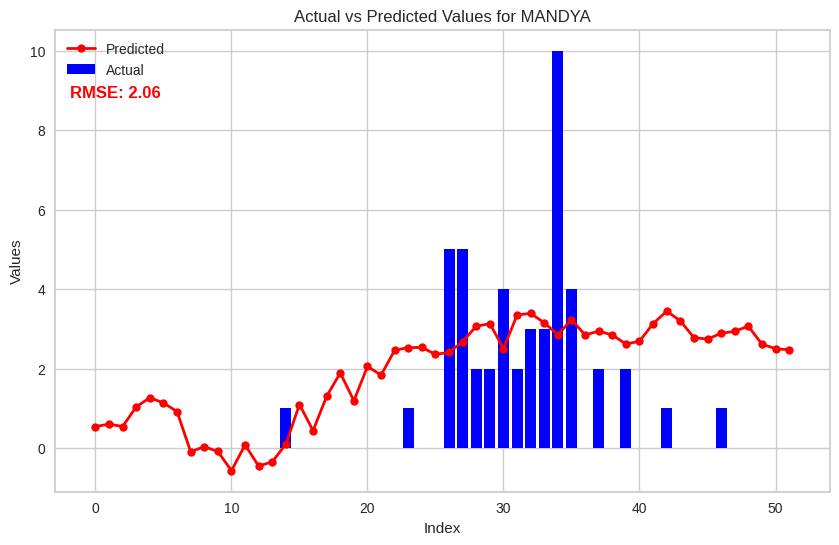

Analyzing District: MYSURU


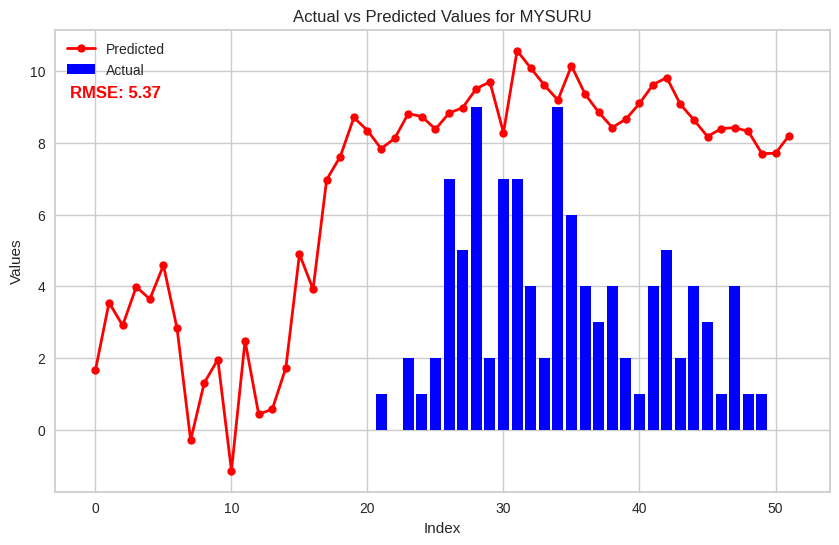

Analyzing District: RAICHUR


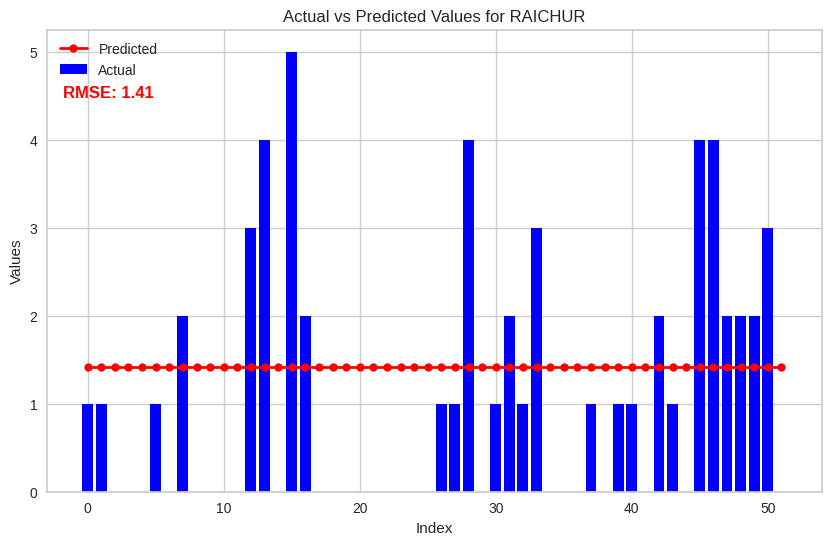

Analyzing District: RAMANAGARA


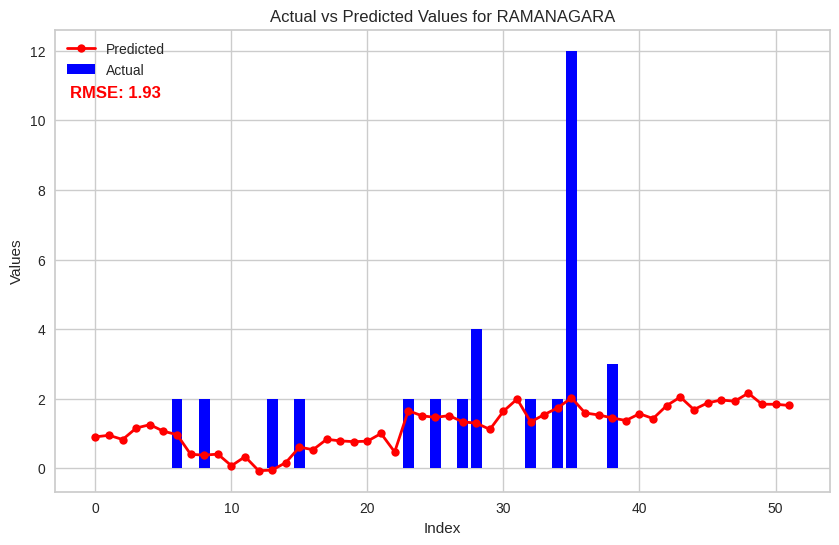

Analyzing District: SHIVAMOGGA


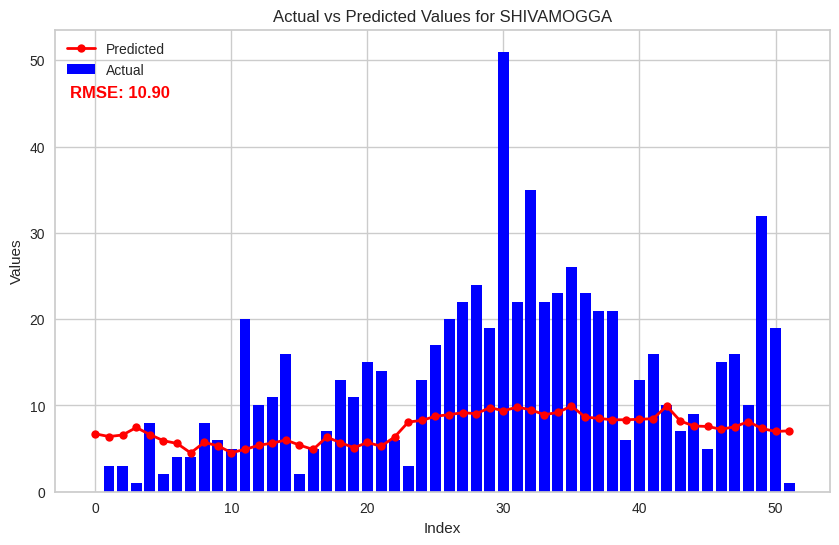

Analyzing District: TUMAKURU


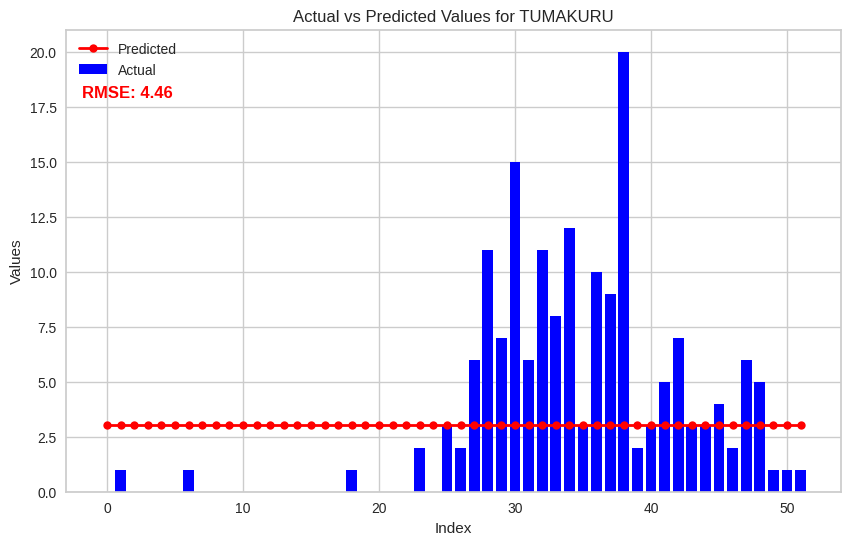

Analyzing District: UDUPI


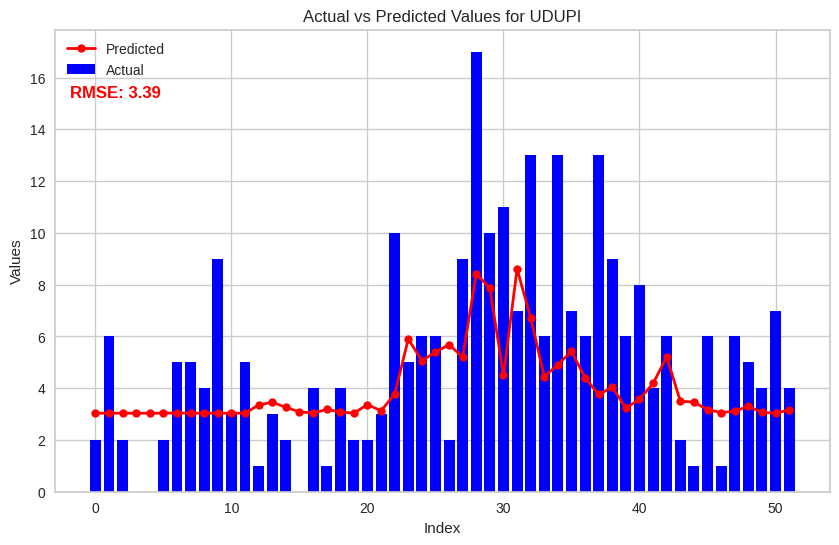

Analyzing District: UTTARA KANNADA


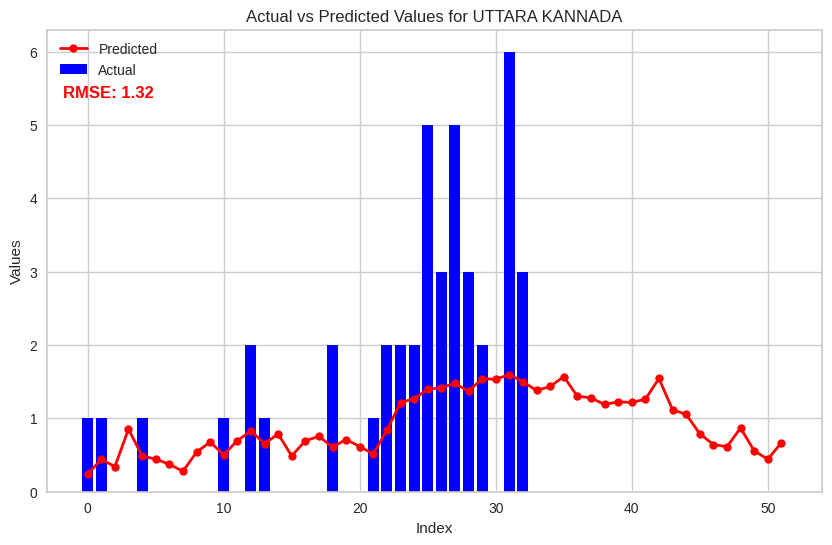

Analyzing District: VIJAYANAGAR


/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

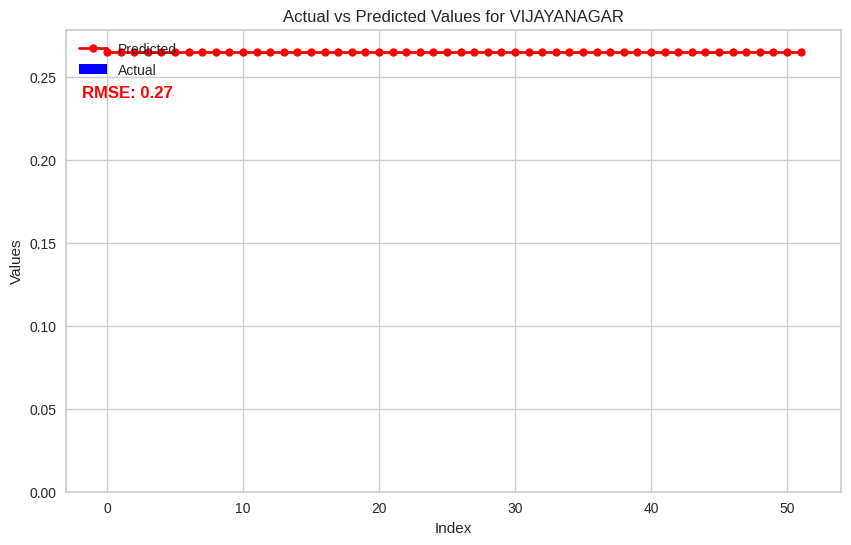

Analyzing District: VIJAYAPURA


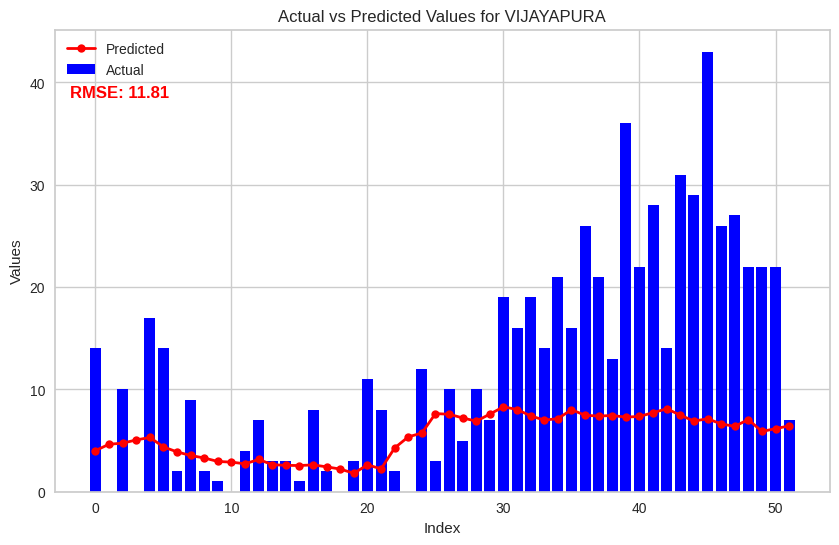

Analyzing District: YADGIR


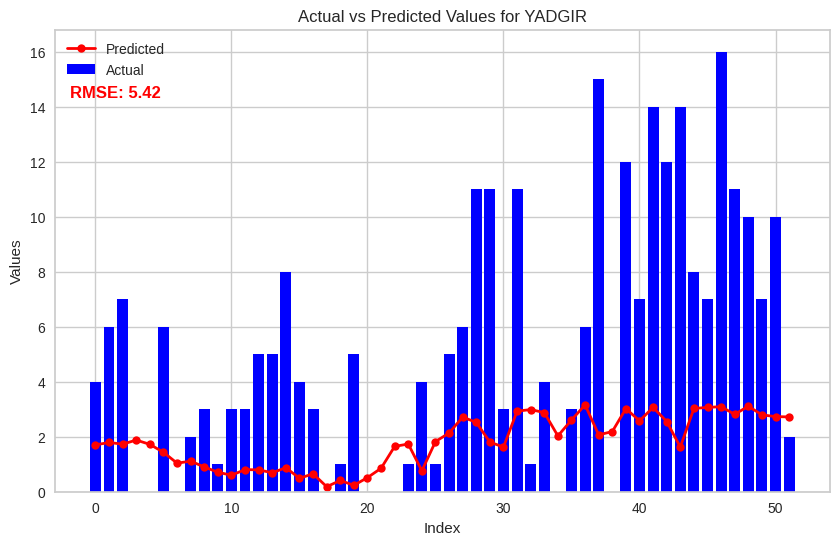

In [28]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2019)
df_2019 = district_analysis.analyze_districts()

Analyzing District: BAGALKOTE


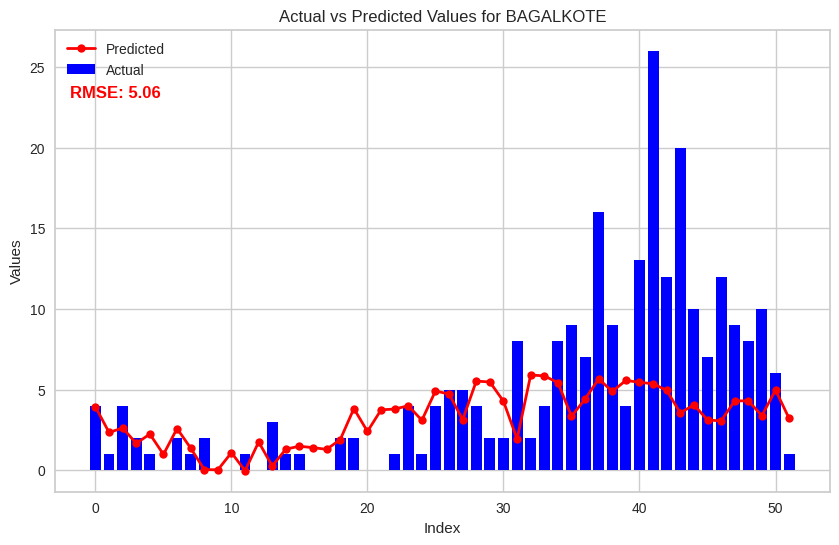

Analyzing District: BALLARI


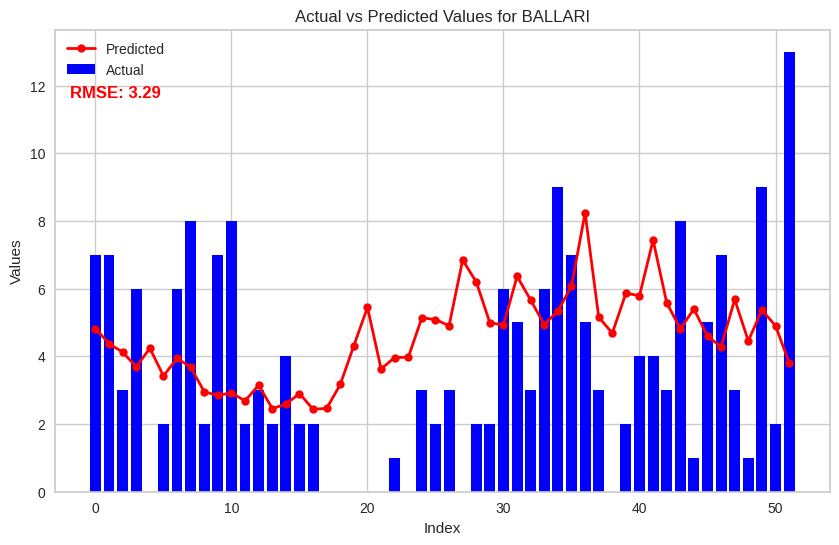

Analyzing District: BELAGAVI


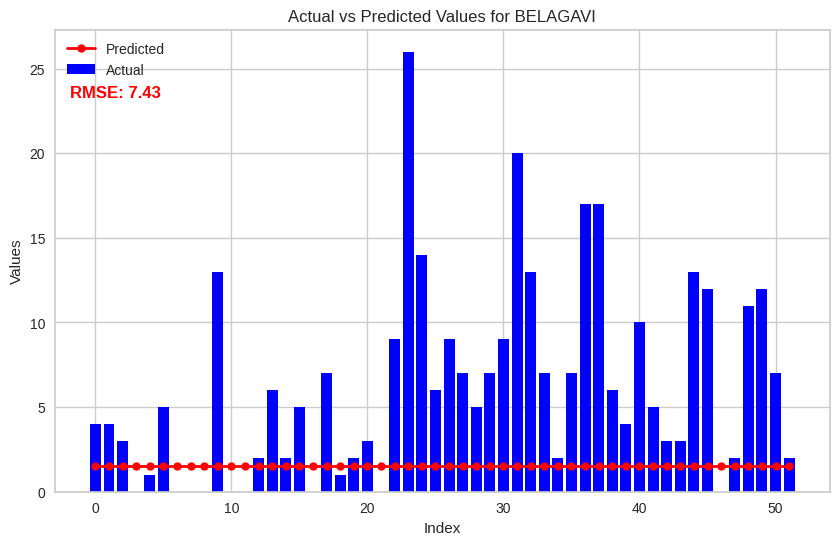

Analyzing District: BENGALURU RURAL


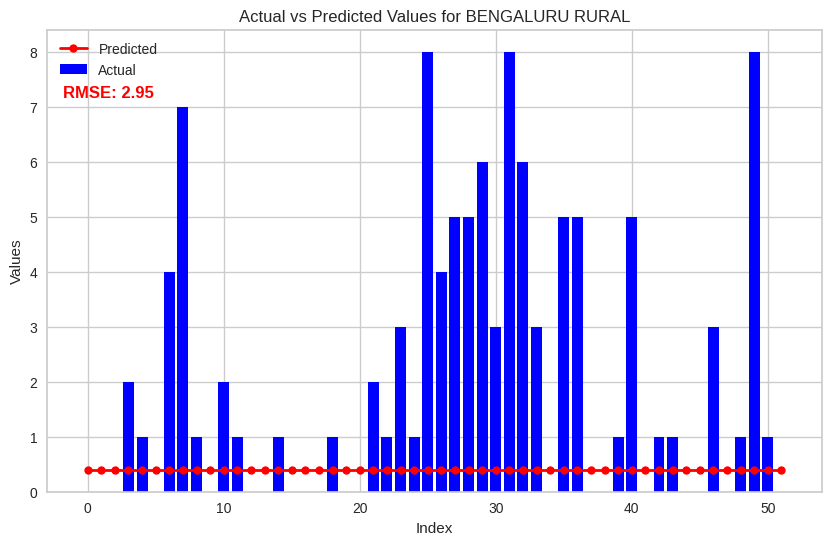

Analyzing District: BENGALURU URBAN


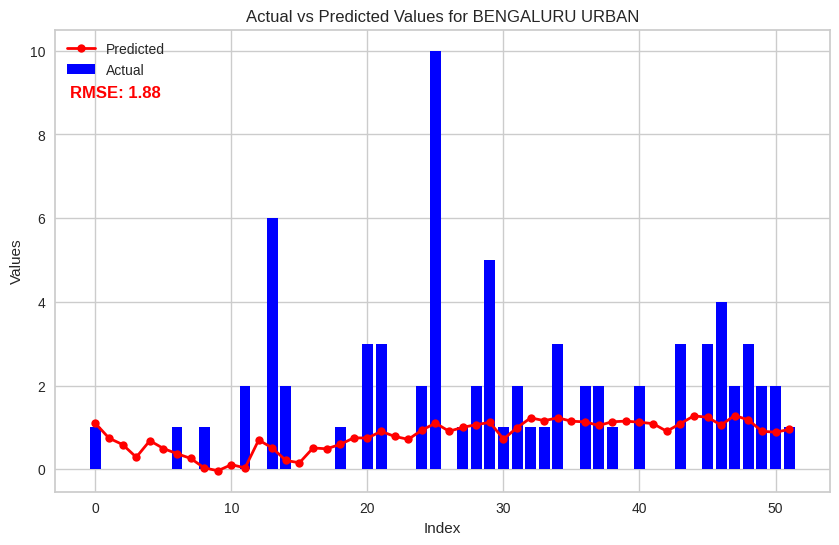

Analyzing District: BIDAR


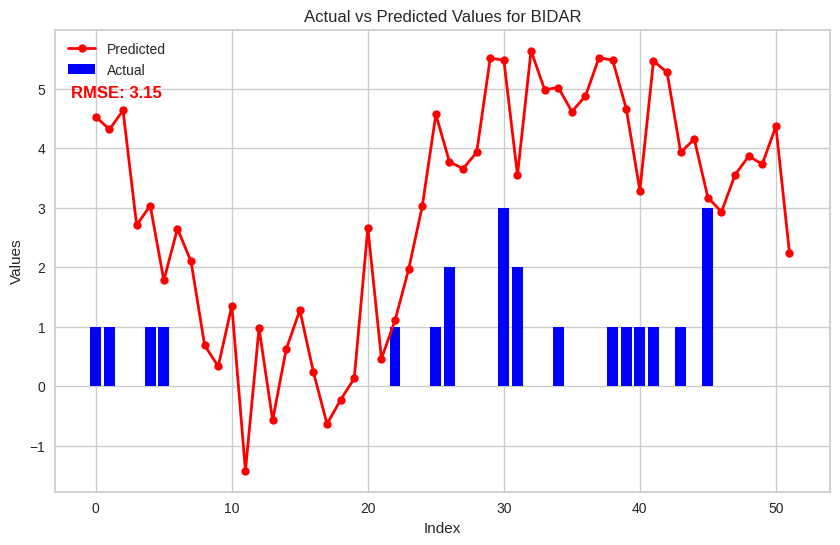

Analyzing District: CHAMARAJANAGARA


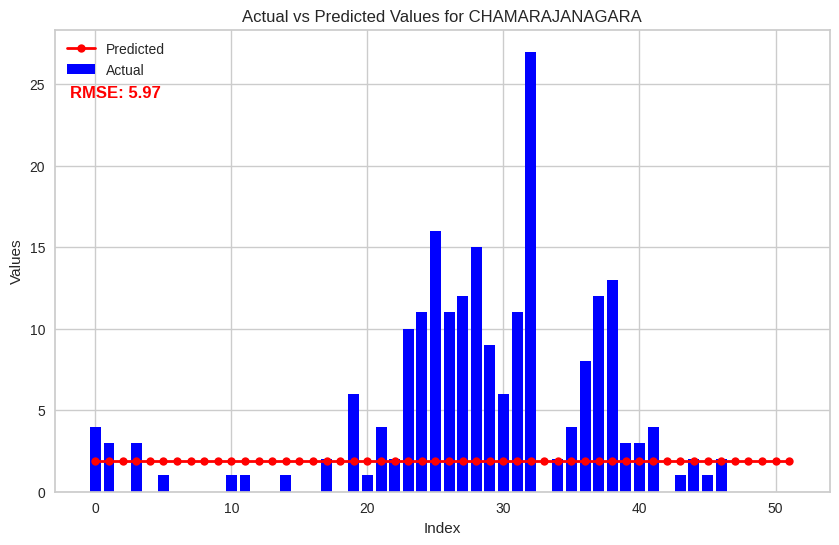

Analyzing District: CHIKKABALLAPURA


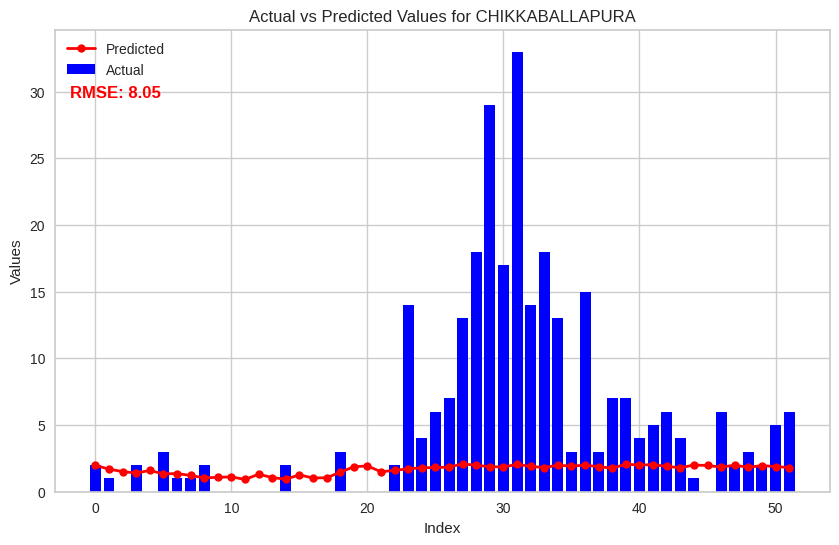

Analyzing District: CHIKKAMAGALURU


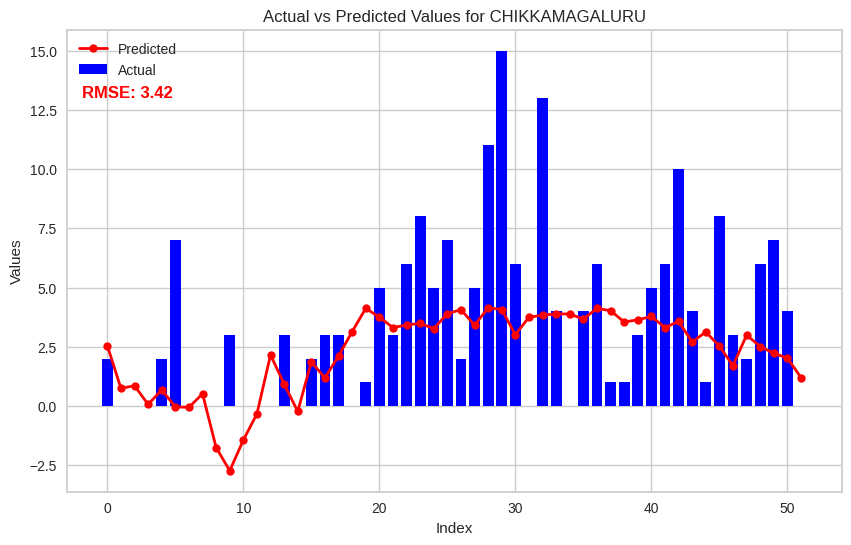

Analyzing District: CHITRADURGA


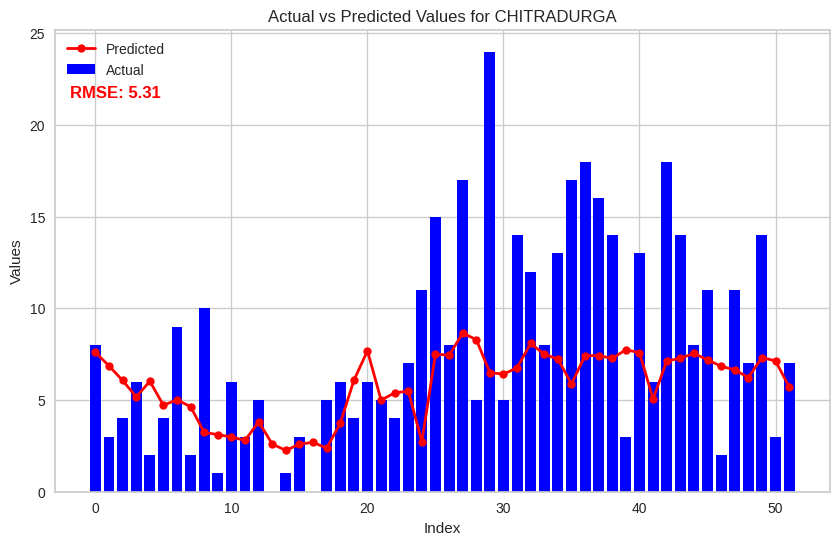

Analyzing District: DAKSHINA KANNADA


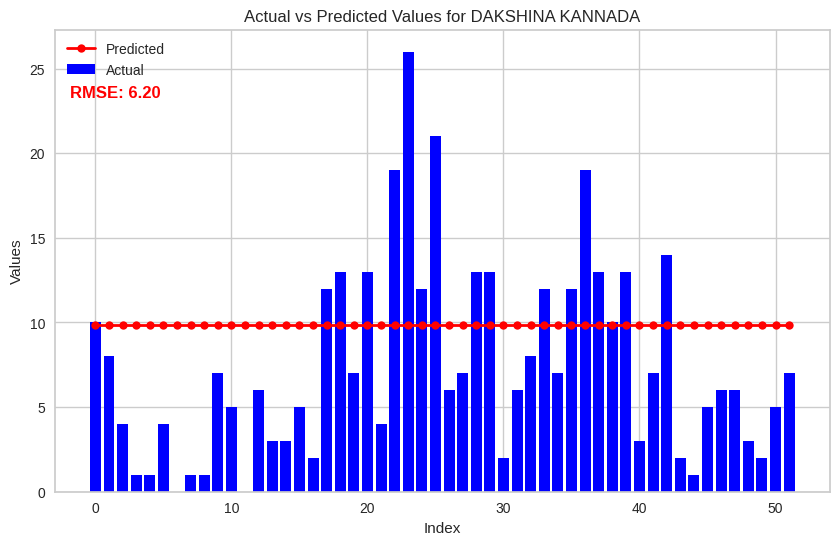

Analyzing District: DAVANGERE


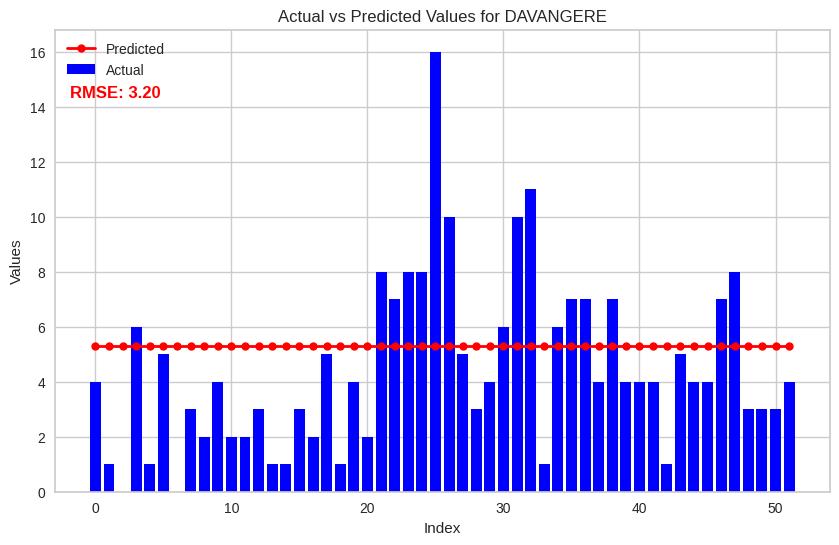

Analyzing District: DHARWAD


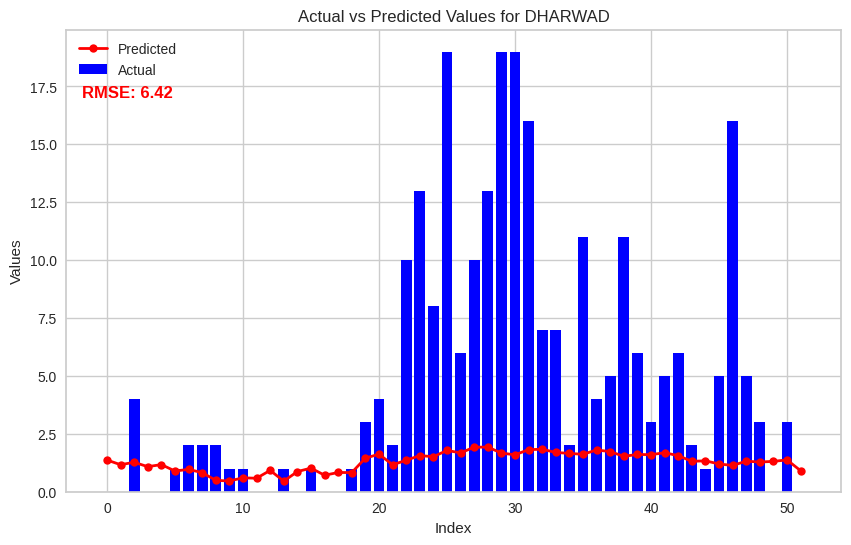

Analyzing District: GADAG


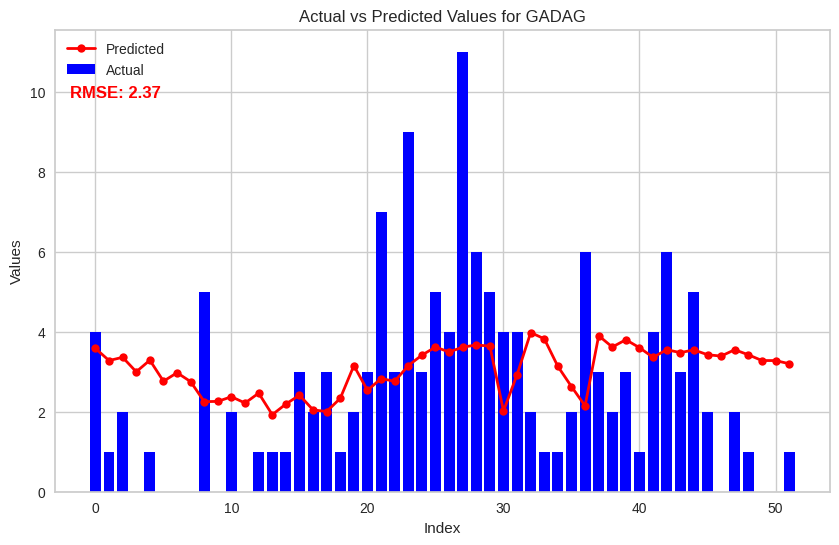

Analyzing District: HASSAN


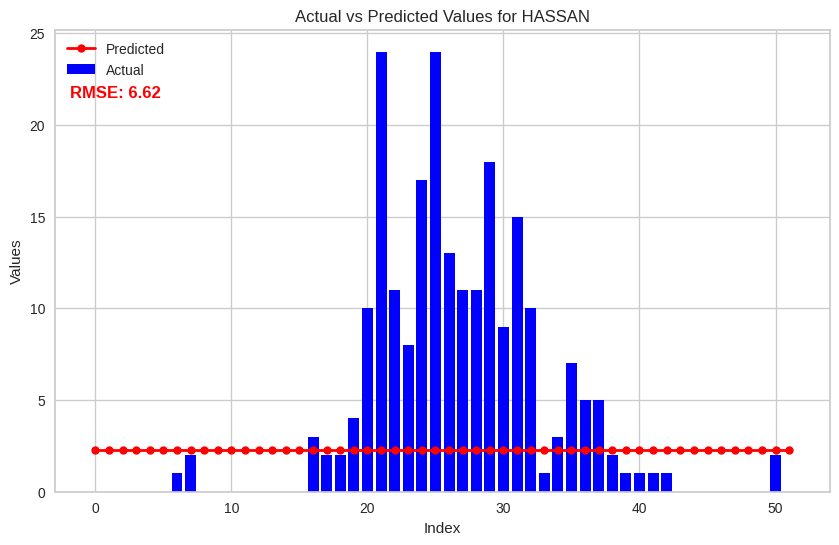

Analyzing District: HAVERI


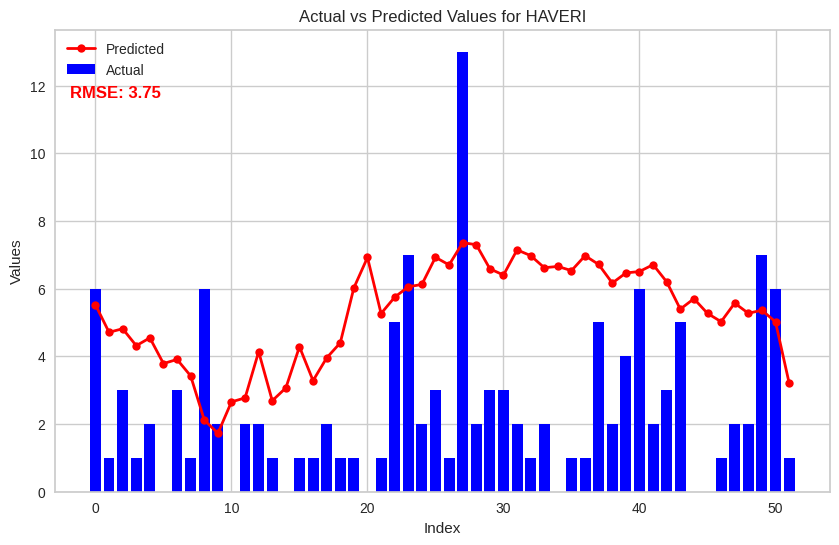

Analyzing District: KALABURAGI


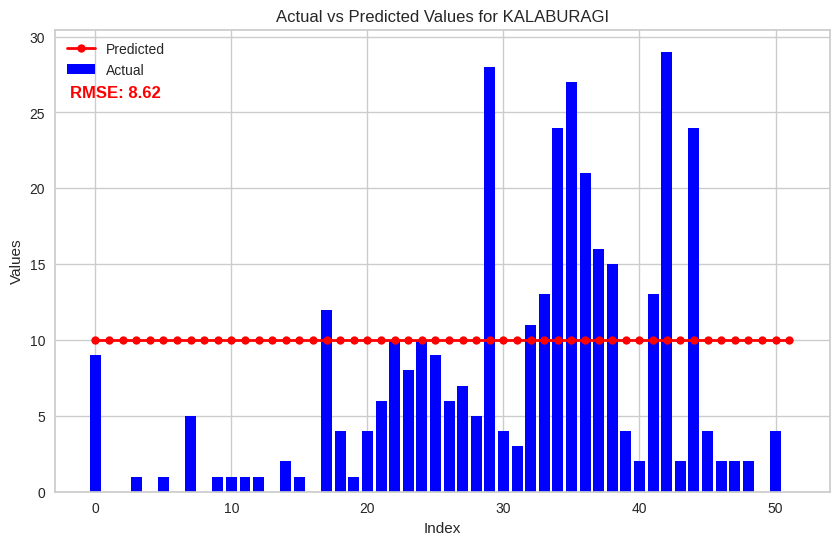

Analyzing District: KODAGU


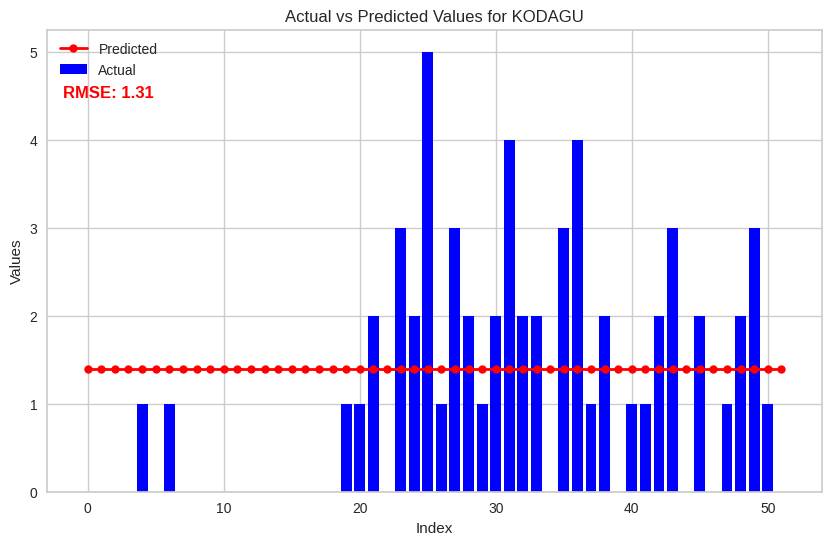

Analyzing District: KOLAR


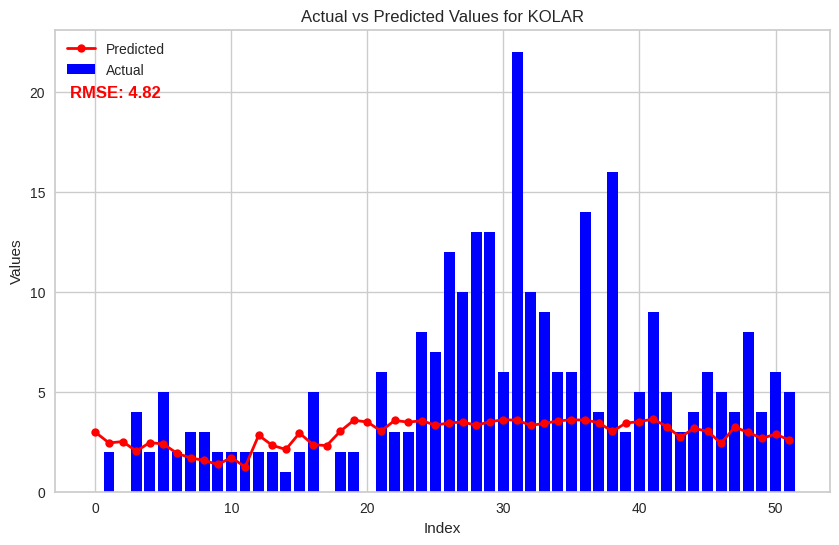

Analyzing District: KOPPAL


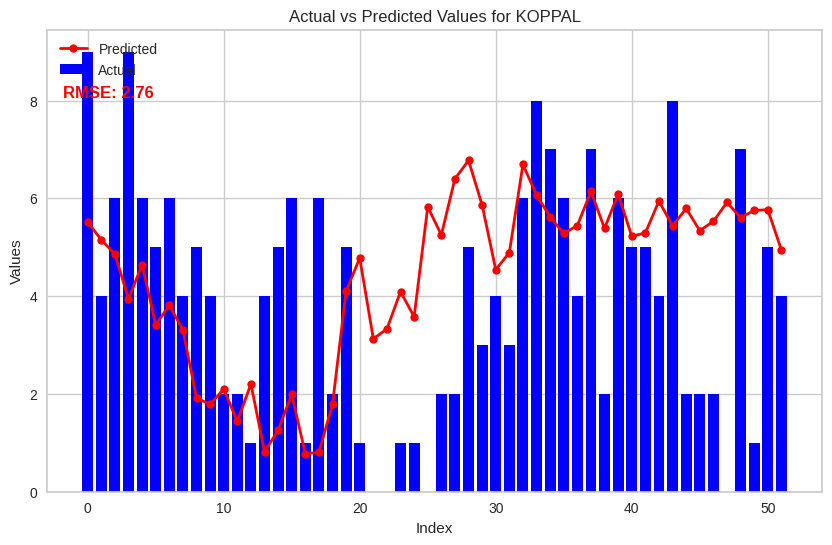

Analyzing District: MANDYA


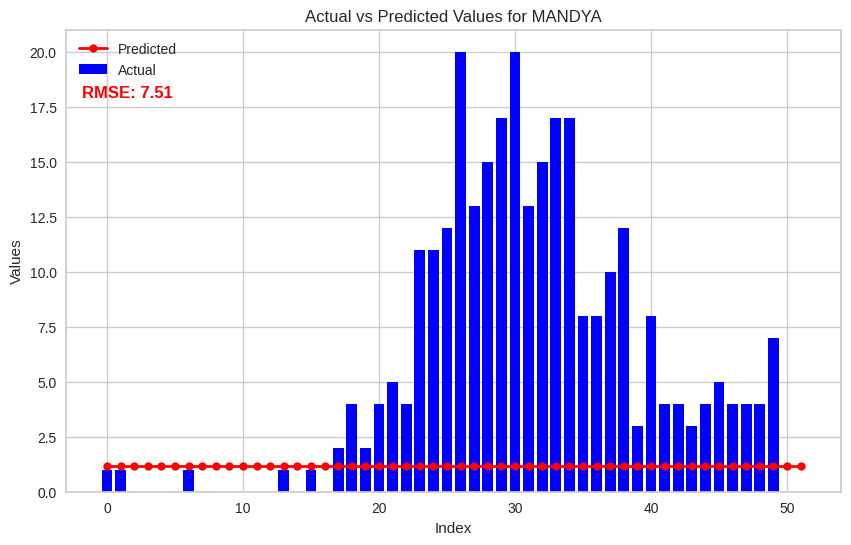

Analyzing District: MYSURU


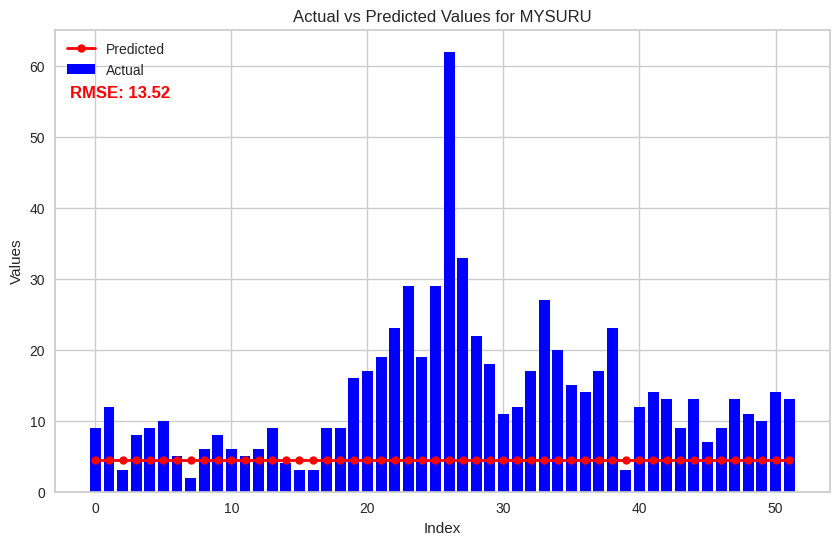

Analyzing District: RAICHUR


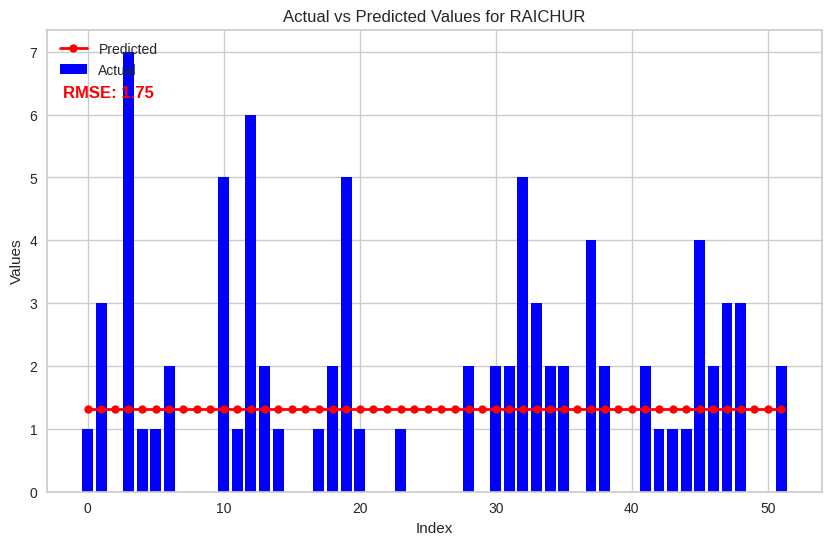

Analyzing District: RAMANAGARA


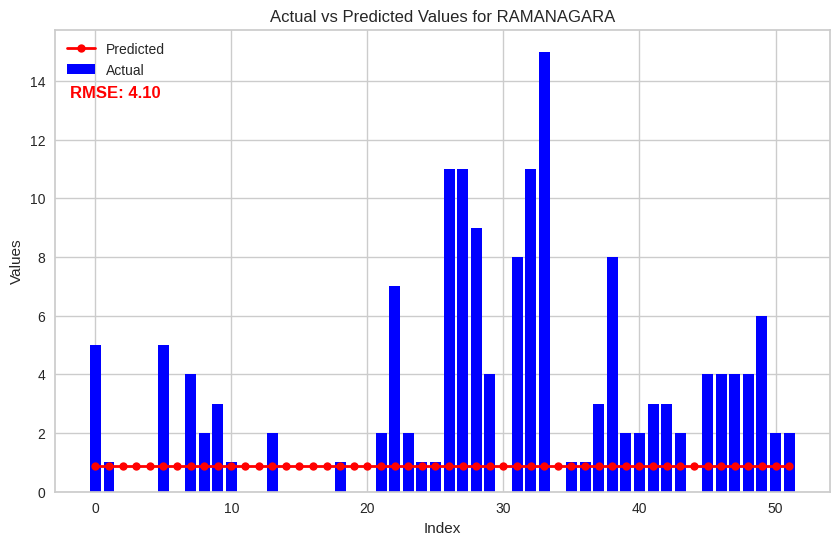

Analyzing District: SHIVAMOGGA


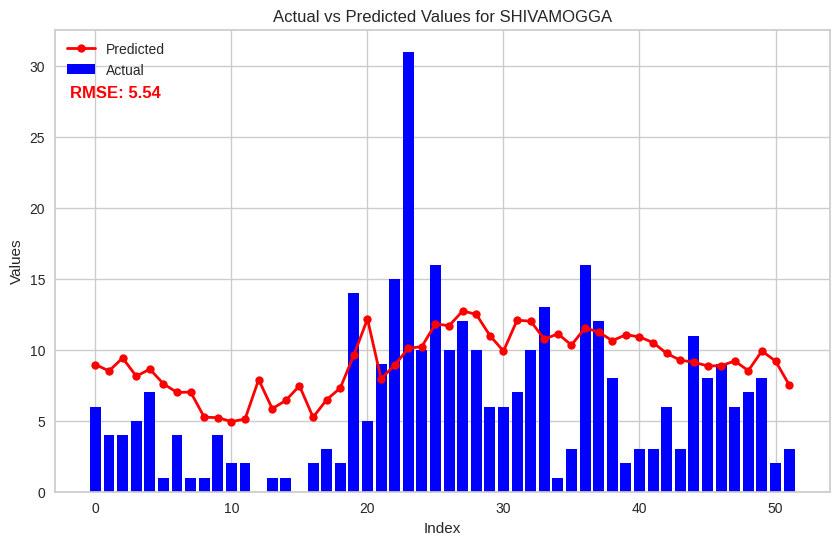

Analyzing District: TUMAKURU


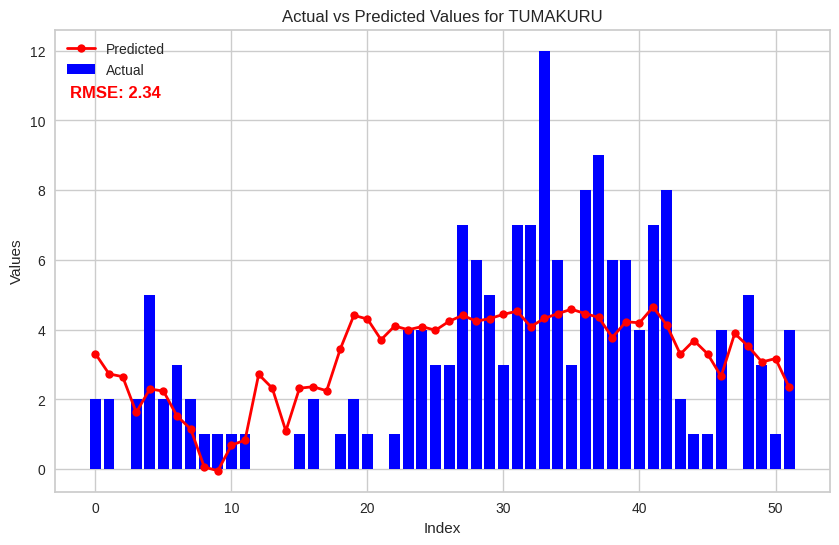

Analyzing District: UDUPI


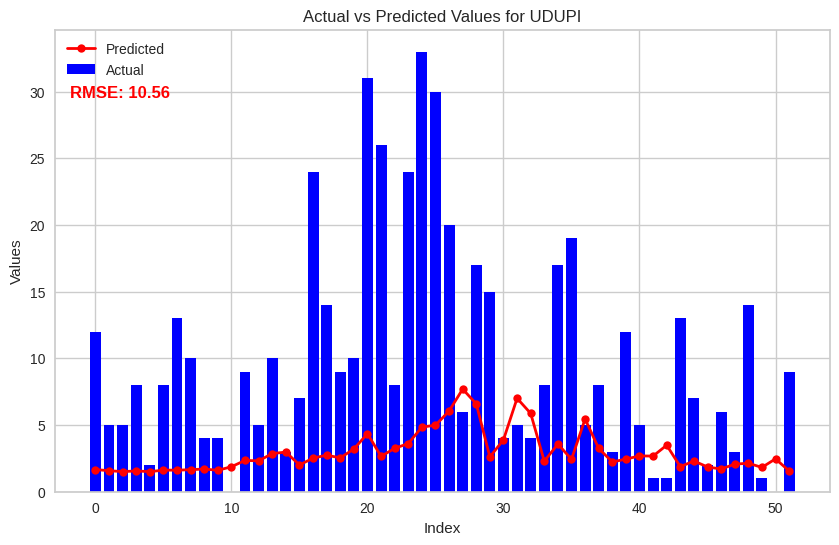

Analyzing District: UTTARA KANNADA


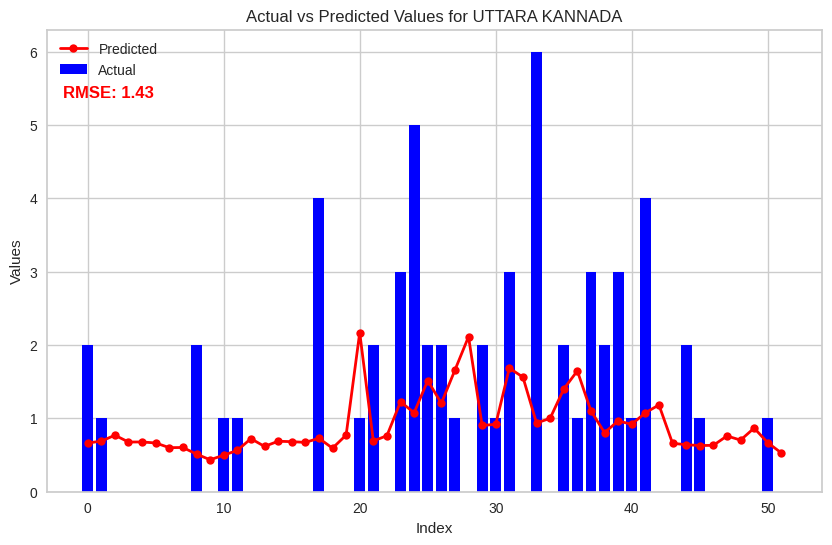

Analyzing District: VIJAYANAGAR


/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/ravi/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap

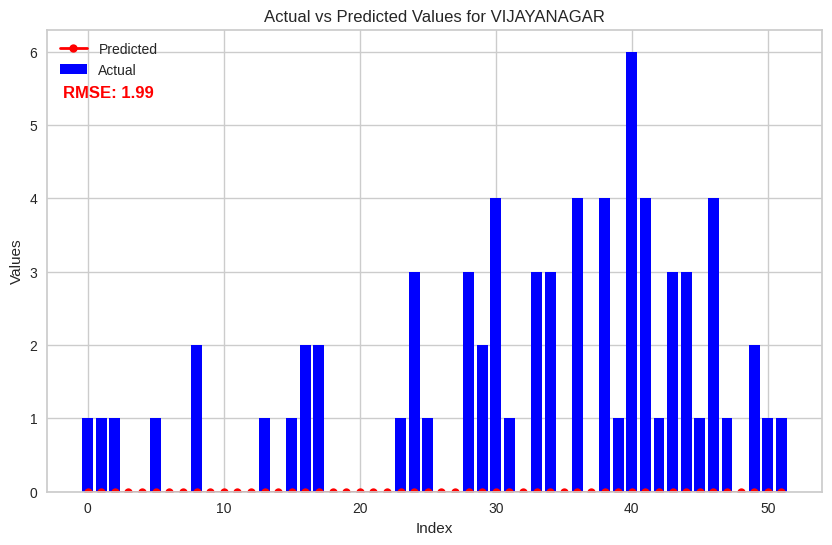

Analyzing District: VIJAYAPURA


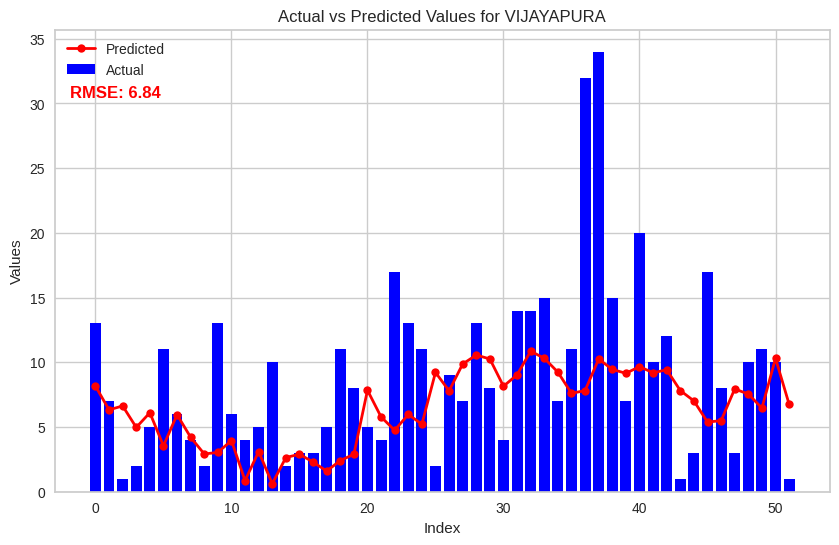

Analyzing District: YADGIR


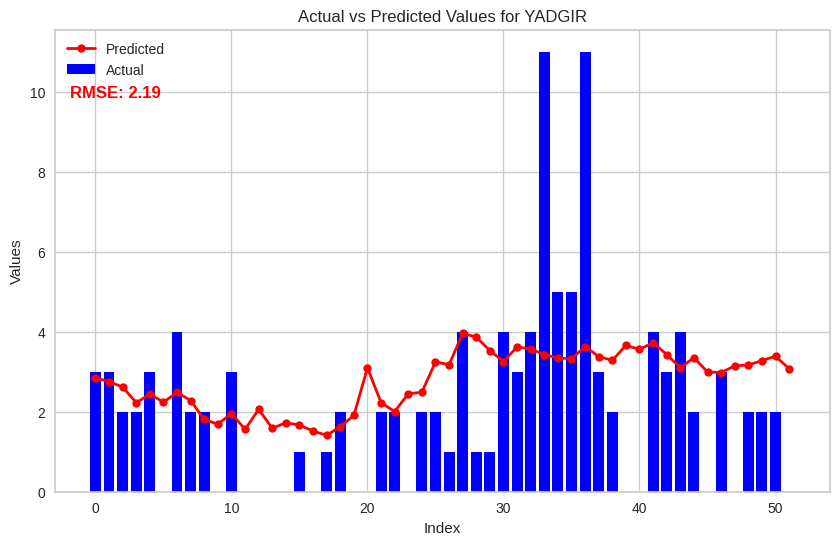

In [29]:
district_analysis = DistrictAnalysis("Karnataka_weather1980to2022.csv",2022)
df_2022 = district_analysis.analyze_districts()

In [30]:
from functools import reduce

# List of DataFrames to merge
dfs = [df_2017, df_2018, df_2019, df_2022]

# Function to merge two DataFrames on 'district' with suffixes
def merge_dfs(left, right):
    return pd.merge(left, right, on='district', suffixes=('', f"_{right.columns[-1][-4:]}"))

# Use reduce to iteratively merge all DataFrames
merged_df = reduce(merge_dfs, dfs)

merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE   6.206098              Bad   3.466895              Bad   
1            BALLARI  10.489468              Bad   3.851199              Bad   
2           BELAGAVI   2.120626              Bad   1.929148             Good   
3    BENGALURU RURAL   0.689318             Good   0.861666             Good   
4    BENGALURU URBAN   1.150022             Good   1.043845             Good   
5              BIDAR   5.098087              Bad   3.477430              Bad   
6    CHAMARAJANAGARA   2.706705              Bad   2.245971              Bad   
7    CHIKKABALLAPURA   2.518103              Bad   2.737270              Bad   
8     CHIKKAMAGALURU   6.675458              Bad   2.541678              Bad   
9        CHITRADURGA   8.976775              Bad   5.466618              Bad   
10  DAKSHINA KANNADA   9.789274              Bad  14.263647              Bad   
11         DAVANGERE  20.504457              Bad   3.943103              Bad   
12           DHARWAD   2.442436              Bad   2.226570              Bad   
13             GADAG   3.480769              Bad   2.458526              Bad   
14            HASSAN   3.328018              Bad   8.611843              Bad   
15            HAVERI   7.079755              Bad   2.889900              Bad   
16        KALABURAGI  28.654095              Bad  18.340147              Bad   
17            KODAGU   8.715176              Bad   1.421780             Good   
18             KOLAR   7.852983              Bad   3.532142              Bad   
19            KOPPAL   4.081015              Bad   4.039649              Bad   
20            MANDYA   2.483006              Bad   2.263266              Bad   
21            MYSURU  23.951726              Bad   6.432040              Bad   
22           RAICHUR   3.312413              Bad   2.000456              Bad   
23        RAMANAGARA   8.366903              Bad   1.475115             Good   
24        SHIVAMOGGA  10.930432              Bad   5.679049              Bad   
25          TUMAKURU  15.580586              Bad   3.667679              Bad   
26             UDUPI   4.818163              Bad   5.143509              Bad   
27    UTTARA KANNADA   1.144537             Good   2.110560              Bad   
28       VIJAYANAGAR   0.265385             Good   0.265385             Good   
29        VIJAYAPURA   5.152538              Bad   5.655385              Bad   
30            YADGIR   2.271351              Bad   2.023910              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0    7.733232              Bad   5.062470              Bad  
1    4.437950              Bad   3.291861              Bad  
2    2.126060              Bad   7.427858              Bad  
3    1.279966             Good   2.951093              Bad  
4    3.804770              Bad   1.883163             Good  
5   10.190757              Bad   3.147228              Bad  
6   10.783205              Bad   5.974497              Bad  
7    5.748494              Bad   8.048725              Bad  
8    4.990268              Bad   3.424309              Bad  
9    7.483090              Bad   5.309098              Bad  
10  48.728927              Bad   6.204433              Bad  
11   5.280685              Bad   3.200363              Bad  
12   1.951827             Good   6.420605              Bad  
13   4.202220              Bad   2.372075              Bad  
14   8.217779              Bad   6.616325              Bad  
15   7.586563              Bad   3.748231              Bad  
16   7.845002              Bad   8.624140              Bad  
17   1.386520             Good   1.312006             Good  
18   4.777186              Bad   4.820217              Bad  
19   6.594820              Bad   2.756817              Bad  
20   2.060720              Bad   7.511588              Bad  
21   5.373627              Bad  13.522664              Bad  
22   1.411654             Good   1.747149       

In [31]:
merged_df = merged_df.round(2)
merged_df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.21              Bad       3.47              Bad   
1            BALLARI      10.49              Bad       3.85              Bad   
2           BELAGAVI       2.12              Bad       1.93             Good   
3    BENGALURU RURAL       0.69             Good       0.86             Good   
4    BENGALURU URBAN       1.15             Good       1.04             Good   
5              BIDAR       5.10              Bad       3.48              Bad   
6    CHAMARAJANAGARA       2.71              Bad       2.25              Bad   
7    CHIKKABALLAPURA       2.52              Bad       2.74              Bad   
8     CHIKKAMAGALURU       6.68              Bad       2.54              Bad   
9        CHITRADURGA       8.98              Bad       5.47              Bad   
10  DAKSHINA KANNADA       9.79              Bad      14.26              Bad   
11         DAVANGERE      20.50              Bad       3.94              Bad   
12           DHARWAD       2.44              Bad       2.23              Bad   
13             GADAG       3.48              Bad       2.46              Bad   
14            HASSAN       3.33              Bad       8.61              Bad   
15            HAVERI       7.08              Bad       2.89              Bad   
16        KALABURAGI      28.65              Bad      18.34              Bad   
17            KODAGU       8.72              Bad       1.42             Good   
18             KOLAR       7.85              Bad       3.53              Bad   
19            KOPPAL       4.08              Bad       4.04              Bad   
20            MANDYA       2.48              Bad       2.26              Bad   
21            MYSURU      23.95              Bad       6.43              Bad   
22           RAICHUR       3.31              Bad       2.00              Bad   
23        RAMANAGARA       8.37              Bad       1.48             Good   
24        SHIVAMOGGA      10.93              Bad       5.68              Bad   
25          TUMAKURU      15.58              Bad       3.67              Bad   
26             UDUPI       4.82              Bad       5.14              Bad   
27    UTTARA KANNADA       1.14             Good       2.11              Bad   
28       VIJAYANAGAR       0.27             Good       0.27             Good   
29        VIJAYAPURA       5.15              Bad       5.66              Bad   
30            YADGIR       2.27              Bad       2.02              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        7.73              Bad       5.06              Bad  
1        4.44              Bad       3.29              Bad  
2        2.13              Bad       7.43              Bad  
3        1.28             Good       2.95              Bad  
4        3.80              Bad       1.88             Good  
5       10.19              Bad       3.15              Bad  
6       10.78              Bad       5.97              Bad  
7        5.75              Bad       8.05              Bad  
8        4.99              Bad       3.42              Bad  
9        7.48              Bad       5.31              Bad  
10      48.73              Bad       6.20              Bad  
11       5.28              Bad       3.20              Bad  
12       1.95             Good       6.42              Bad  
13       4.20              Bad       2.37              Bad  
14       8.22              Bad       6.62              Bad  
15       7.59              Bad       3.75              Bad  
16       7.85              Bad       8.62              Bad  
17       1.39             Good       1.31             Good  
18       4.78              Bad       4.82              Bad  
19       6.59              Bad       2.76              Bad  
20       2.06              Bad       7.51              Bad  
21       5.37              Bad      13.52              Bad  
22       1.41             Good       1.75       

In [32]:
merged_df.to_csv('lasso_performance.csv', index=False)

In [33]:
df = pd.read_csv("lasso_performance.csv")
df

district  2017_rmse 2017_performance  2018_rmse 2018_performance  \
0          BAGALKOTE       6.21              Bad       3.47              Bad   
1            BALLARI      10.49              Bad       3.85              Bad   
2           BELAGAVI       2.12              Bad       1.93             Good   
3    BENGALURU RURAL       0.69             Good       0.86             Good   
4    BENGALURU URBAN       1.15             Good       1.04             Good   
5              BIDAR       5.10              Bad       3.48              Bad   
6    CHAMARAJANAGARA       2.71              Bad       2.25              Bad   
7    CHIKKABALLAPURA       2.52              Bad       2.74              Bad   
8     CHIKKAMAGALURU       6.68              Bad       2.54              Bad   
9        CHITRADURGA       8.98              Bad       5.47              Bad   
10  DAKSHINA KANNADA       9.79              Bad      14.26              Bad   
11         DAVANGERE      20.50              Bad       3.94              Bad   
12           DHARWAD       2.44              Bad       2.23              Bad   
13             GADAG       3.48              Bad       2.46              Bad   
14            HASSAN       3.33              Bad       8.61              Bad   
15            HAVERI       7.08              Bad       2.89              Bad   
16        KALABURAGI      28.65              Bad      18.34              Bad   
17            KODAGU       8.72              Bad       1.42             Good   
18             KOLAR       7.85              Bad       3.53              Bad   
19            KOPPAL       4.08              Bad       4.04              Bad   
20            MANDYA       2.48              Bad       2.26              Bad   
21            MYSURU      23.95              Bad       6.43              Bad   
22           RAICHUR       3.31              Bad       2.00              Bad   
23        RAMANAGARA       8.37              Bad       1.48             Good   
24        SHIVAMOGGA      10.93              Bad       5.68              Bad   
25          TUMAKURU      15.58              Bad       3.67              Bad   
26             UDUPI       4.82              Bad       5.14              Bad   
27    UTTARA KANNADA       1.14             Good       2.11              Bad   
28       VIJAYANAGAR       0.27             Good       0.27             Good   
29        VIJAYAPURA       5.15              Bad       5.66              Bad   
30            YADGIR       2.27              Bad       2.02              Bad   

    2019_rmse 2019_performance  2022_rmse 2022_performance  
0        7.73              Bad       5.06              Bad  
1        4.44              Bad       3.29              Bad  
2        2.13              Bad       7.43              Bad  
3        1.28             Good       2.95              Bad  
4        3.80              Bad       1.88             Good  
5       10.19              Bad       3.15              Bad  
6       10.78              Bad       5.97              Bad  
7        5.75              Bad       8.05              Bad  
8        4.99              Bad       3.42              Bad  
9        7.48              Bad       5.31              Bad  
10      48.73              Bad       6.20              Bad  
11       5.28              Bad       3.20              Bad  
12       1.95             Good       6.42              Bad  
13       4.20              Bad       2.37              Bad  
14       8.22              Bad       6.62              Bad  
15       7.59              Bad       3.75              Bad  
16       7.85              Bad       8.62              Bad  
17       1.39             Good       1.31             Good  
18       4.78              Bad       4.82              Bad  
19       6.59              Bad       2.76              Bad  
20       2.06              Bad       7.51              Bad  
21       5.37              Bad      13.52              Bad  
22       1.41             Good       1.75       